# Conocimiento de código

## Librerías y funciones

In [300]:
import pandas as pd
import numpy as np
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from pandas.plotting import scatter_matrix
from category_encoders import TargetEncoder# pip install category_encoders
from category_encoders import BinaryEncoder
warnings.filterwarnings('ignore', category=DeprecationWarning)


def ver_Nan(df,columns):
    for column in columns:
        text = f'NaN? - {column.upper()} '
        
        isNa = df[column].isna().any()
        print(f'{text.ljust(50)} {isNa}')

def standard_scale(df):
    '''Devuelve un dataframe con las columnas escaladas'''
    scaler = StandardScaler()
    string = df.select_dtypes(include=['object']).columns #solo vamos a escalar las columnas que no son string
    df_no_string = df.drop(string,axis=1)
    df_no_string = scaler.fit_transform(df_no_string)
    df_no_string = pd.DataFrame(df_no_string,columns=df.drop(string,axis=1).columns)
    df_escaled = df.copy()
    df_escaled[df_no_string.columns] = df_no_string
    return df_escaled

def boxplot(df):
    '''Devuelve un boxplot de df'''
    df_escaled = standard_scale(df)
    sns.boxplot(data=df_escaled,orient='h')

def rango_outliers(df):
    '''Devuelve el rango de outliers de df, definidas por min y max'''
    df_escaled = standard_scale(df)
    Q1 = df_escaled.quantile(0.25)
    Q3 = df_escaled.quantile(0.75)
    IQR = Q3 - Q1
    min = Q1 - 1.5*IQR
    max = Q3 + 1.5*IQR
    return min,max

def outliers(df):
    '''Devuelve un dataframe con los outliers de df, y una columna llamada outliers con las columnas que son outliers'''
    df_escaled = standard_scale(df)
    min,max = rango_outliers(df)
    columnas_no_string = df.select_dtypes(exclude=['object']).columns
    premisa = (df_escaled[columnas_no_string] < min) | (df_escaled[columnas_no_string] > max)
    indexes = df_escaled[premisa].dropna(axis=0,how='all').index
    df_outliers_bool = df_escaled[premisa].dropna(axis=0,how='all').isna()
    df_outliers = df.loc[indexes]
    columnas = df_outliers.columns
    dict = {i:[j for j in columnas if df_outliers_bool.loc[i][j] == False] for i in indexes}
    df_outliers['outliers'] = dict.values()
    return df_outliers

def bar_plot(df,column:list):
    length = len(column)
    fig,ax = plt.subplots(1,length,figsize=(20,5))
    for i in range(length):
        #quiero qu lo string se vean en vertical
        sns.countplot(x=column[i],data=df,ax=ax[i])#los strin del eje x se solapan y no se ven, hay que rotarlos
        ax[i].tick_params(axis='x', rotation=90)


        ax[i].set_title(column[i])
        ax[i].set_ylabel('Count')
        ax[i].set_xlabel('')

def csv(predicciones,nombre,df_test):
    y_pred = pd.DataFrame({'id':df_test['id'],'Predicted':predicciones})
    y_pred['Predicted'] = y_pred['Predicted'].astype(int)
    y_pred.to_csv(nombre,index=False)

def corr_representation(train):
    ax, fig = plt.subplots(1,3,figsize=(20,5))

    corr_1 = train['Comb (L/100 km)'].corr(train['Fuel Consumption City (L/100 km)'])
    corr_2 = train['Comb (L/100 km)'].corr(train['Hwy (L/100 km)'])
    corr_3 = train['Fuel Consumption City (L/100 km)'].corr(train['Hwy (L/100 km)'])

    fig[0].scatter(train['Comb (L/100 km)'],train['Fuel Consumption City (L/100 km)'])
    fig[0].plot(np.unique(train['Comb (L/100 km)']), np.poly1d(np.polyfit(train['Comb (L/100 km)'], train['Fuel Consumption City (L/100 km)'], 1))(np.unique(train['Comb (L/100 km)'])),color='red')
    fig[0].legend([f'Correlación: {corr_1}'])

    fig[1].scatter(train['Comb (L/100 km)'],train['Hwy (L/100 km)'])
    fig[1].plot(np.unique(train['Comb (L/100 km)']), np.poly1d(np.polyfit(train['Comb (L/100 km)'], train['Hwy (L/100 km)'], 1))(np.unique(train['Comb (L/100 km)'])),color='red')
    fig[1].legend([f'Correlación: {corr_2}'])

    fig[2].scatter(train['Hwy (L/100 km)'],train['Fuel Consumption City (L/100 km)'])
    fig[2].plot(np.unique(train['Hwy (L/100 km)']), np.poly1d(np.polyfit(train['Hwy (L/100 km)'], train['Fuel Consumption City (L/100 km)'], 1))(np.unique(train['Hwy (L/100 km)'])),color='red')
    fig[2].legend([f'Correlación: {corr_3}'])


def r_2_regresion_lineal(df,x:list,y:list):
    reg = LinearRegression().fit(df[x],df[y])
    parametres = reg.coef_
    ax, fig = plt.subplots(1,3,figsize=(20,5))
    calculo = parametres[0][0]*df[x[0]] + parametres[0][1]*df[x[1]]
    r_2 = reg.score(df[x],df[y])
    fig[0].plot(df[y],calculo,color='red')
    fig[0].scatter(df[y],df[y],color='blue')
    fig[0].set_title(f'r_2: {r_2}')
    error = df['Comb (L/100 km)'] - calculo
    sns.distplot(error,ax=fig[1])

    qqplot(error,ax=fig[2],line='s')
    
    test = stats.kstest(error, 'norm')
    
    print(f'r_2: {r_2}')
    print('Test de normalidad (kolmogorov-smirnov):')
    print(test)


    


## Lectura de datos

Vamos a primero comprender los disntintos datasets que nos han facilitado el concurso. Para ello, vamos a cargar los datos y a ver qué información contienen.

In [271]:
directorio = '../apau-smog-prediction/'
lista = os.listdir(directorio)
for i in lista:
    exec(i.split('.')[0] + ' = pd.read_csv(directorio + i)')


- sample_subsimmision, ejemplo de cómo debe ser el fichero de salida (la predicción)
- test_nolabel, datos de test sin etiquetar (podemos observar que no tenemos la columna de la etiqueta -Smog-)
- train, datos de entrenamiento 



In [3]:
sample_submission.head()

,id,Predicted
0,2be023f9102,2
1,a320ba7de7b,3
2,2879e8fa078,0
3,a561b6ee65b,2
4,94c225dd8e9,1


In [4]:
test_nolabel.head()

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km)
0,2be023f9102,2022,Jeep,Wagoneer 4X4,SUV: Standard,5.7,8,A8,X,15.6,11.7,13.8,20,323
1,a320ba7de7b,2022,Porsche,718 Boxster,Two-seater,2.0,4,M6,Z,11.7,8.9,10.5,27,245
2,2879e8fa078,2022,Chrysler,Grand Caravan,Minivan,3.6,6,A9,X,12.4,8.4,10.6,27,249
3,a561b6ee65b,2022,Kia,Sorento AWD,SUV: Small,2.5,4,AM8,X,10.9,8.7,9.9,29,234
4,94c225dd8e9,2022,Bentley,Continental GT,Subcompact,4.0,8,AM8,Z,14.9,9.0,12.2,23,287


In [5]:
train.head()

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
0,ab44e9bec15,2022,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,32,202,2
1,45926762371,2022,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,37,181,4
2,e9be56e153f,2022,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,24,274,2
3,077092760df,2022,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,35,189,1
4,c1c2579b795,2022,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1


Nuestras variables son:
- Model Year: año del modelo
- Make: marca del coche
- Model: modelo del coche
- Vehicle Class: clase del vehículo
- Engine Size: tamaño del motor
- Cylinders: número de cilindros
- Transmission: tipo de transmisión
- Fuel Type: tipo de combustible
- Fuel Consumption City (L/100 km): consumo de combustible en ciudad
- Hwy (L/100 km): consumo de combustible en carretera
- Comb (L/100 km): consumo de combustible combinado
- Fuel Consumption Comb (mpg): consumo de combustible combinado (millas por galón)
- CO2 Emissions(g/km): emisiones 

## Exploración de atributos

In [6]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                586 non-null    object 
 1   Model Year                        586 non-null    int64  
 2   Make                              586 non-null    object 
 3   Model                             586 non-null    object 
 4   Vehicle Class                     586 non-null    object 
 5   Engine Size (L)                   586 non-null    float64
 6   Cylinders                         586 non-null    int64  
 7   Transmission                      586 non-null    object 
 8   Fuel Type                         586 non-null    object 
 9   Fuel Consumption City (L/100 km)  586 non-null    float64
 10  Hwy (L/100 km)                    586 non-null    float64
 11  Comb (L/100 km)                   586 non-null    float64
 12  Comb (mp

In [7]:
test_nolabel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                390 non-null    object 
 1   Model Year                        390 non-null    int64  
 2   Make                              390 non-null    object 
 3   Model                             390 non-null    object 
 4   Vehicle Class                     390 non-null    object 
 5   Engine Size (L)                   390 non-null    float64
 6   Cylinders                         390 non-null    int64  
 7   Transmission                      390 non-null    object 
 8   Fuel Type                         390 non-null    object 
 9   Fuel Consumption City (L/100 km)  390 non-null    float64
 10  Hwy (L/100 km)                    390 non-null    float64
 11  Comb (L/100 km)                   390 non-null    float64
 12  Comb (mp

### Variables categoricas

### Model Year

El atributo Model Year es un atributo numérico que representa el año del modelo del coche. 

In [8]:
test_nolabel['Model Year'].unique()

array([2022], dtype=int64)

In [9]:
train['Model Year'].unique()

array([2022], dtype=int64)

Podemos observar que los coches del dataset son modelos del año 2022. Al ser todos del mismo año, este atributo no nos aporta información y por tanto, no lo vamos a tener en cuenta en nuestro modelo.

In [10]:
train = train.drop('Model Year',axis=1)
test_nolabel = test_nolabel.drop('Model Year',axis=1)

### Make, Model y Vehicle Class

Vamos a estudiar estos tres atributos juntos, ya que los tres nos aportan información sobre el tipo de coche.
- Make: marca del coche
- Model: modelo del coche
- Vehicle Class: clase del vehículo

Se puede dar que uno de los tres atributos sea redundante, es decir, uno de ellos se pueda obtener a partir de los otros dos. Para comprobarlo, vamos a ver cuántos valores únicos tiene cada uno de ellos.

In [11]:
assert (train.groupby('Model')['Make'].nunique() == 1).all()

Como hemos visto en la celda anterior hemos demostrado que ningún modelo viene de distintas marcas, por lo que podríamos suponer
que el atributo Make es redundante. Sin embargo, no lo eliminamos ya que agrupa los modelos por marcas y puede ser interesante

### Fuel Type y Transmission

- Fuel Type: tipo de combustible
- Transmission: tipo de transmisión, que puede ser automática o manual<>

In [12]:
train['Fuel Type'].unique()

array(['Z', 'X', 'E', 'D'], dtype=object)

In [13]:
len(train)+len(test_nolabel)

976

In [14]:
train['Transmission'].unique()

array(['AM7', 'AS6', 'AM8', 'A8', 'AS8', 'M6', 'A10', 'AS10', 'A9', 'M7',
       'AV8', 'AS9', 'AV', 'AM6', 'AS7', 'AV10', 'AV7', 'A6', 'AM9', 'M5',
       'AV6', 'AS5', 'AV1'], dtype=object)

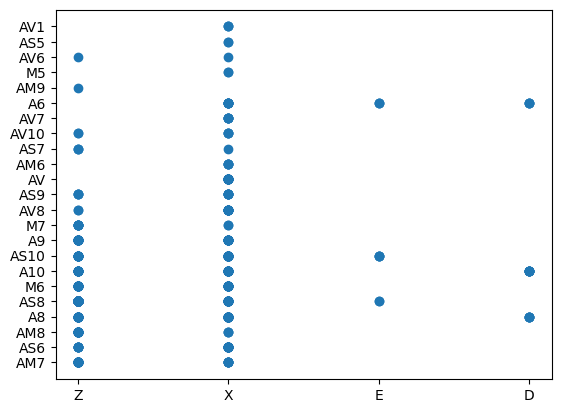

In [15]:
plt.scatter(train['Fuel Type'],train['Transmission'])

### Variables numéricas

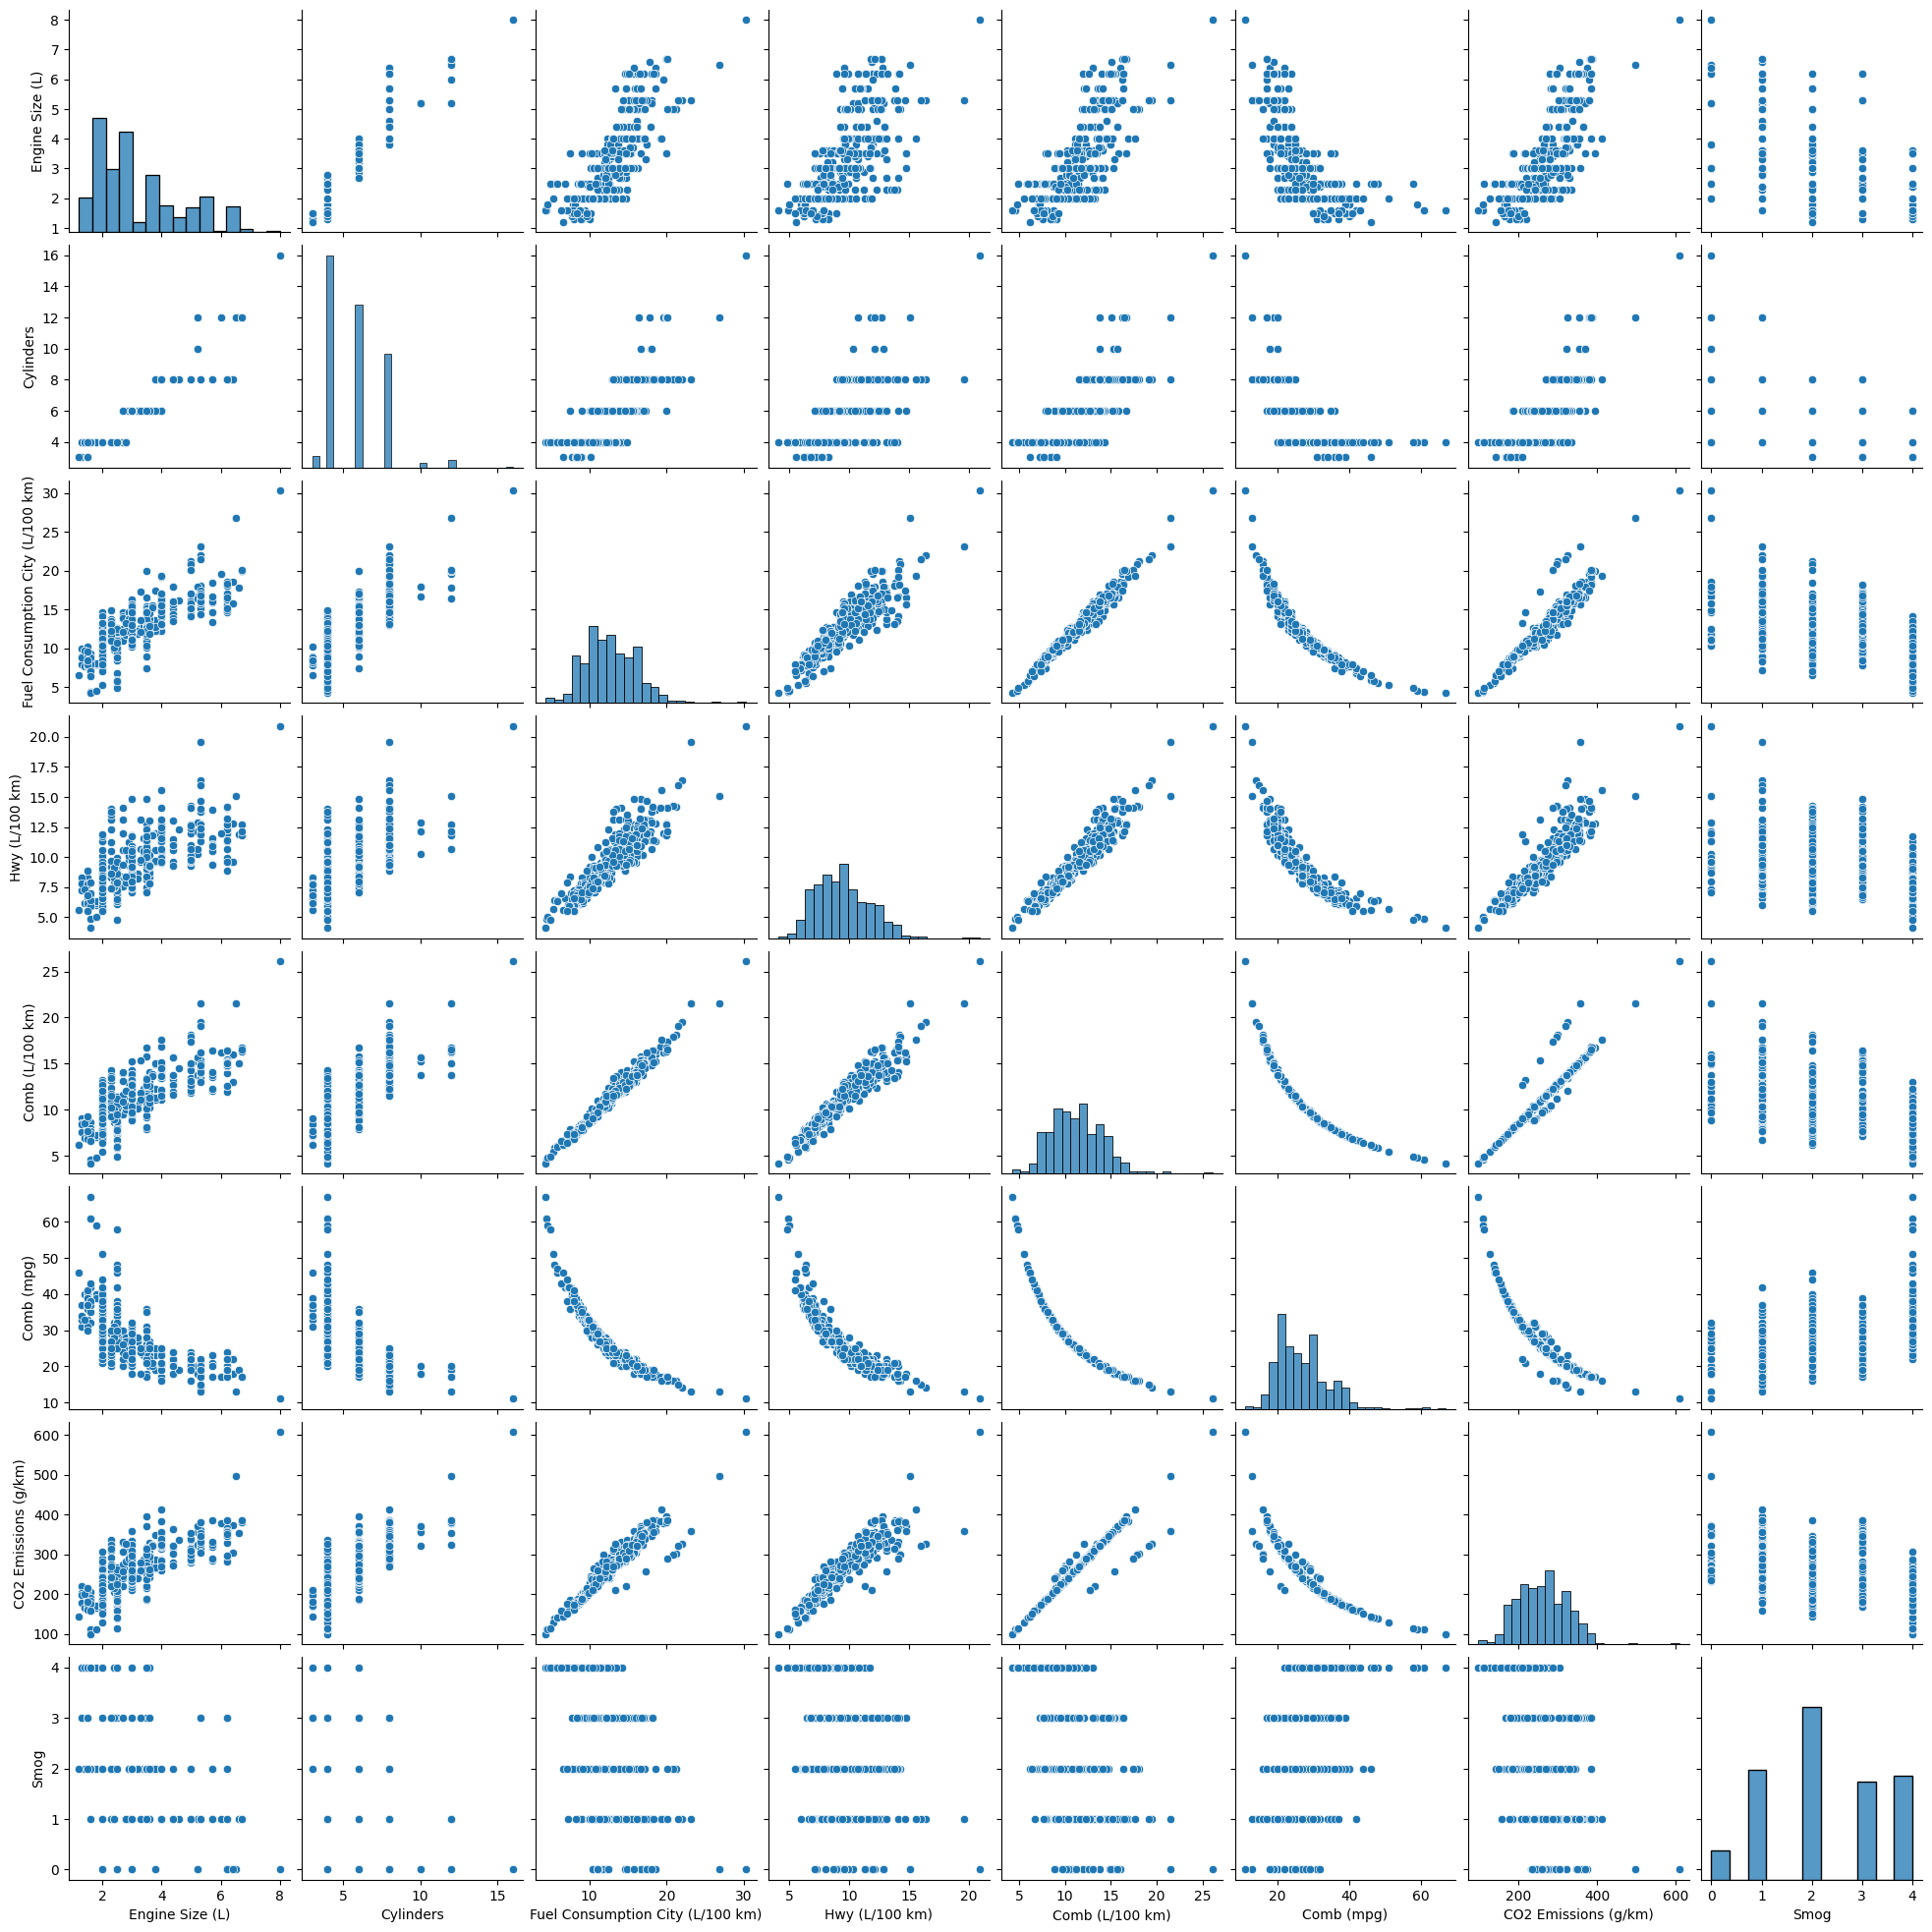

In [16]:
sns.pairplot(train)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singul

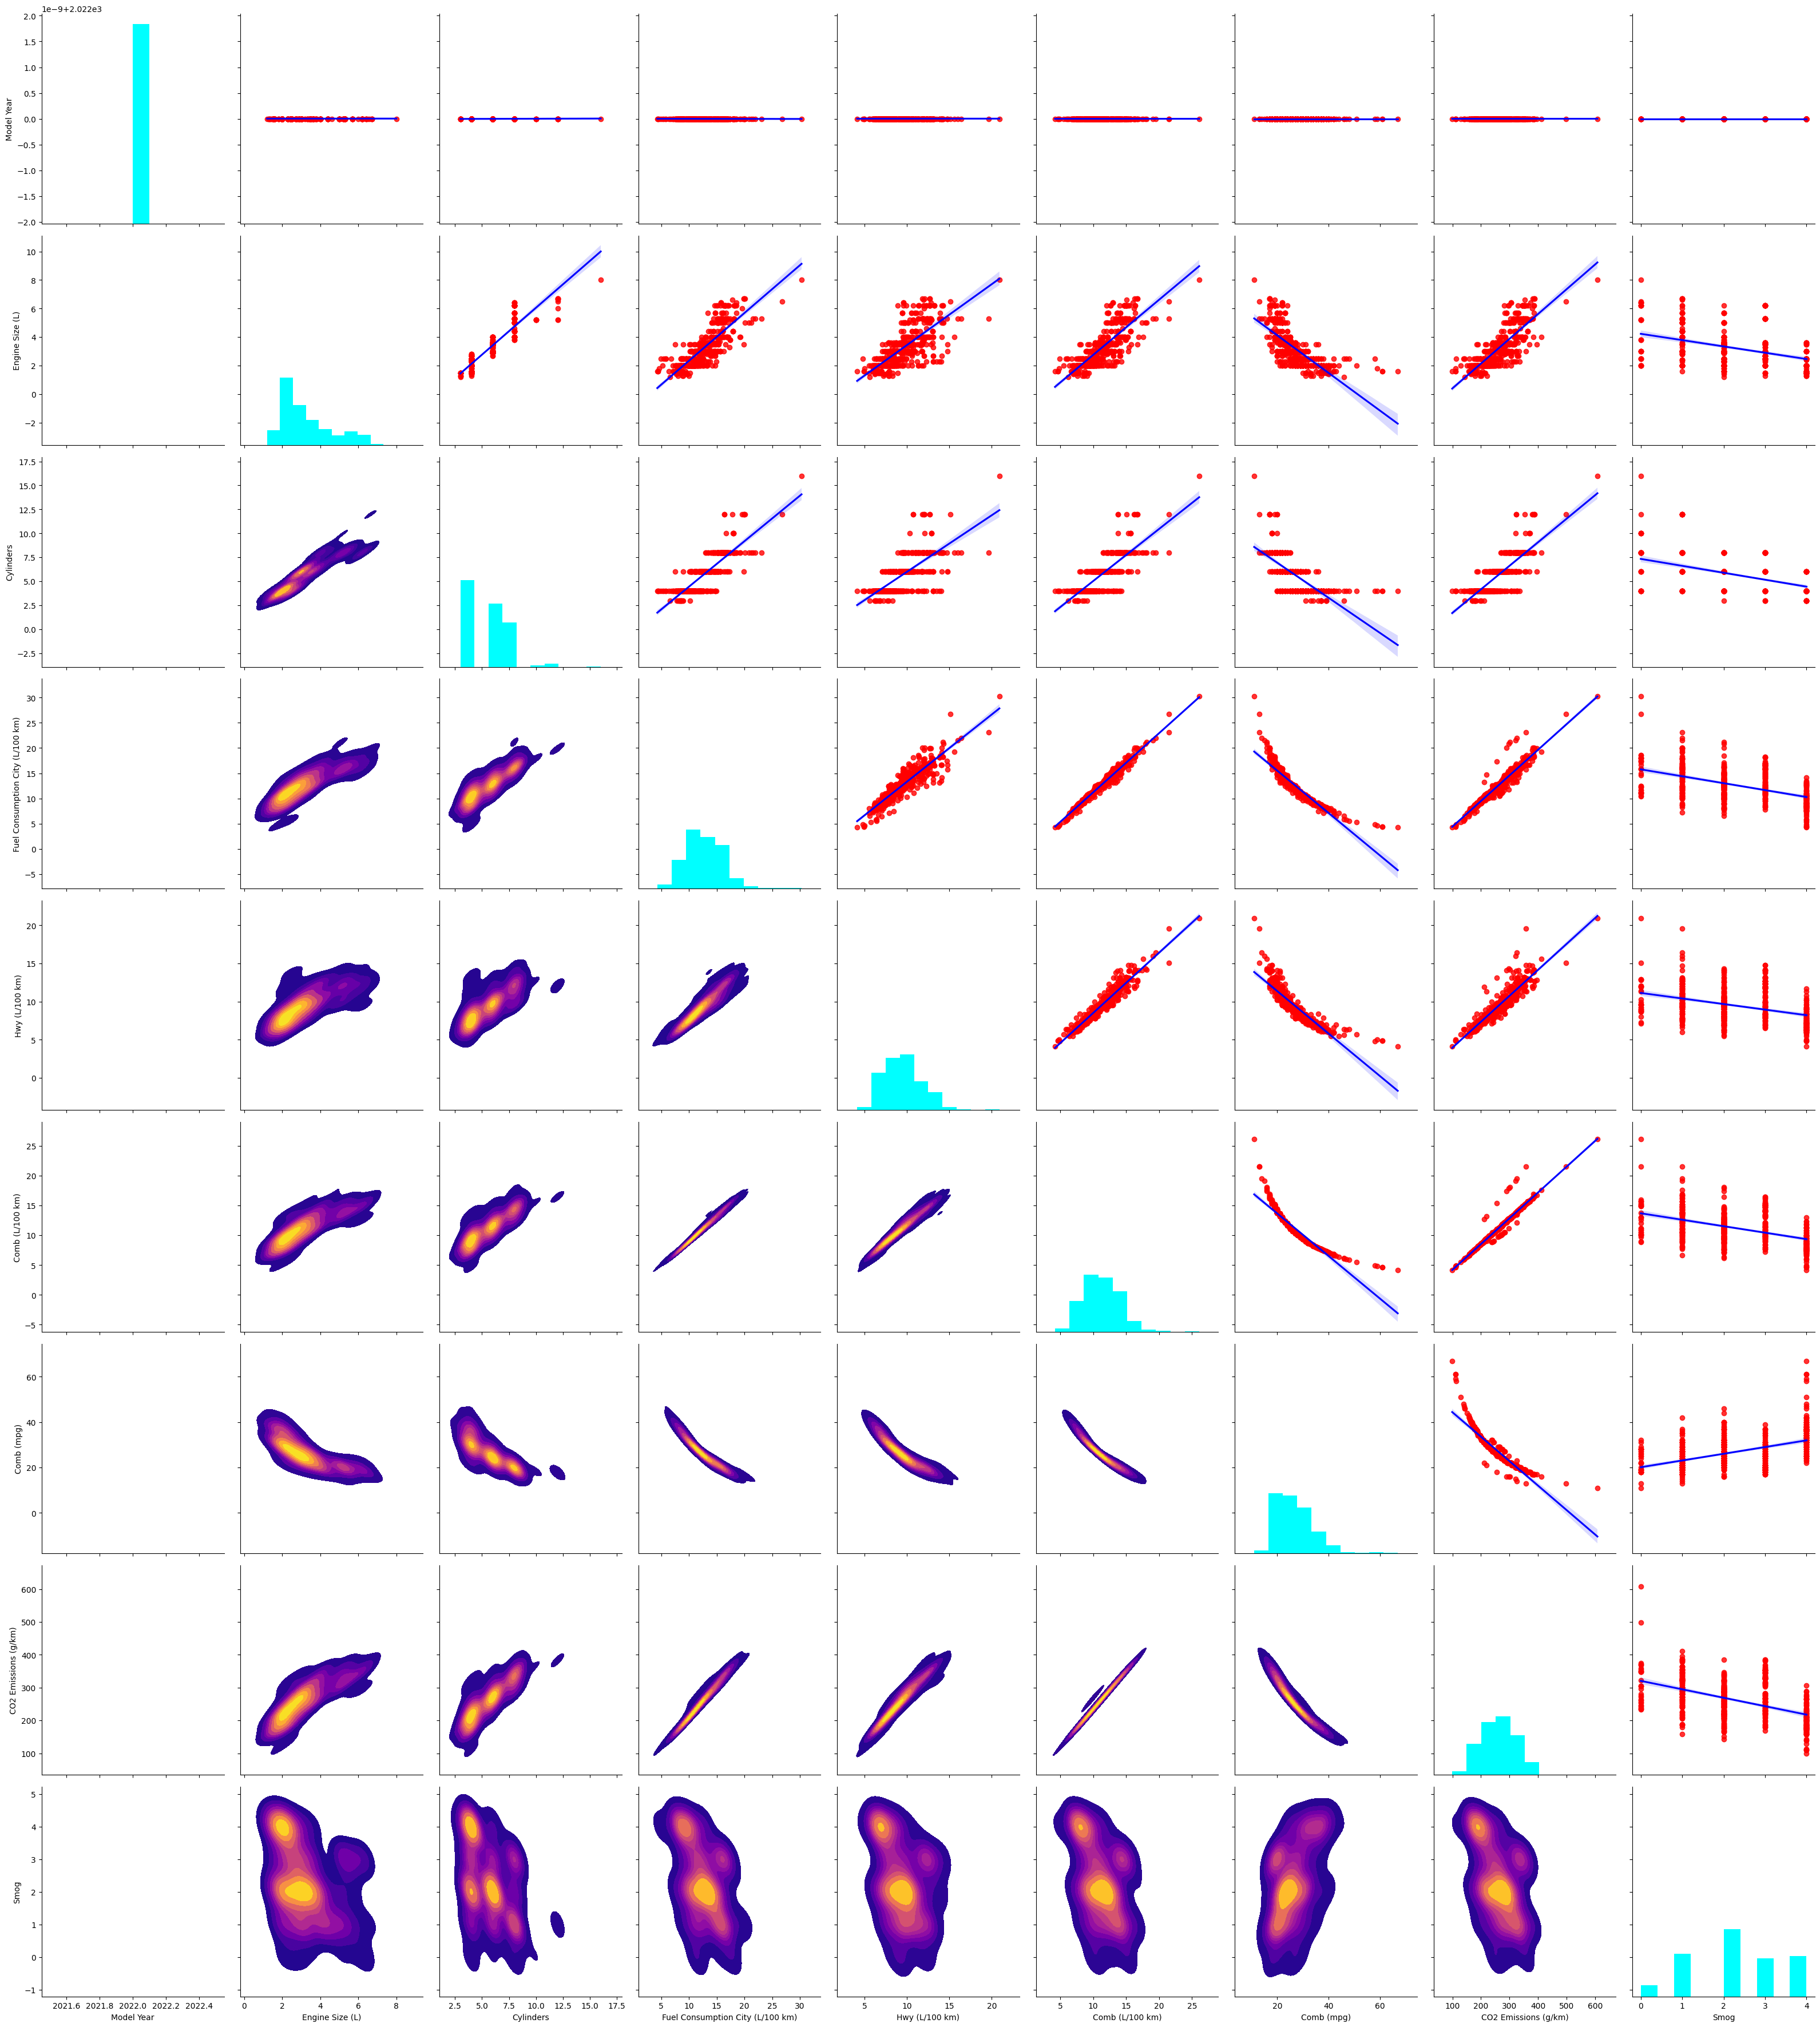

In [272]:
columnas_numericas = train.select_dtypes(exclude=['object']).columns
g = sns.PairGrid(train[columnas_numericas], height=4, aspect=0.9)
g.map_upper(sns.regplot,scatter_kws={"color": "red"}, line_kws={"color": "blue"})
g.map_lower(sns.kdeplot, cmap="plasma", shade=True, thresh=0.05)
g.map_diag(plt.hist,color = 'cyan')
plt.tight_layout
plt.show()

<Axes: >

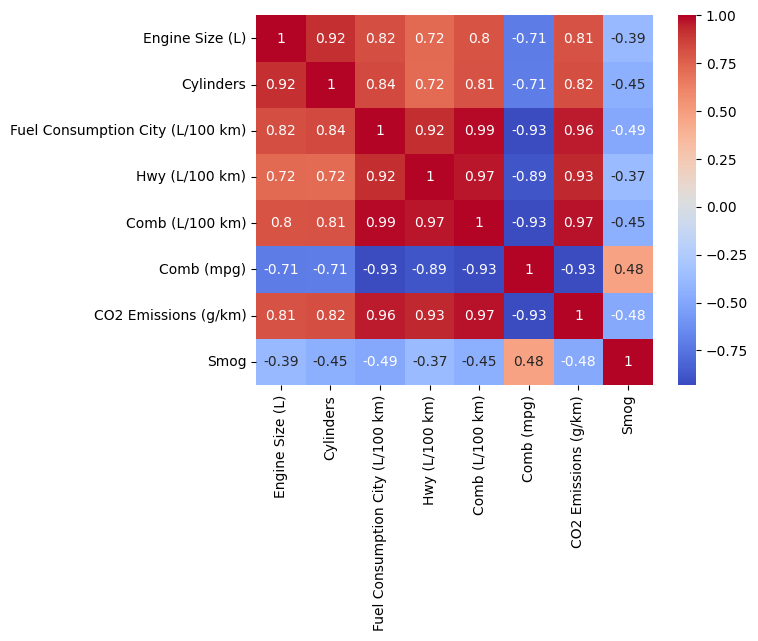

In [19]:
## mapa de calor correalación con sns
sns.heatmap(train[columnas_numericas].corr(),annot=True,cmap='coolwarm')

### Engine Size y Cylinders

- Engine Size: tamaño del motor
- Cylinders: número de cilindros


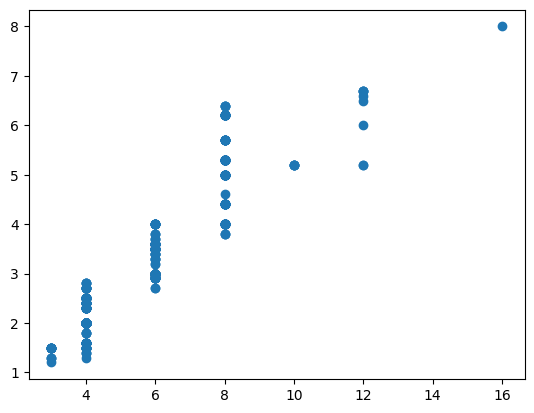

In [20]:
plt.scatter(train['Cylinders'],train['Engine Size (L)'])

In [21]:
train.head()

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
0,ab44e9bec15,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,32,202,2
1,45926762371,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,37,181,4
2,e9be56e153f,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,24,274,2
3,077092760df,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,35,189,1
4,c1c2579b795,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1


### Fuel Consumption City,  Hwy, Comb (L/100 km), Comb (mpg) y CO2 Emissions

- Fuel Consumption City (L/100 km): consumo de combustible en ciudad
- Hwy (L/100 km): consumo de combustible en carretera
- Comb (L/100 km): consumo de combustible combinado
- Comb (mpg): consumo de combustible combinado (millas por galón)
- CO2 Emissions(g/km): emisiones

#### Comb (mpg) y Comb (L/100 km)

Podemos observar de primeras que tenemos dos atributos que nos dan la misma información, pero en distintas unidades. Estos son Comb (L/100 km) y Comb (mpg). 

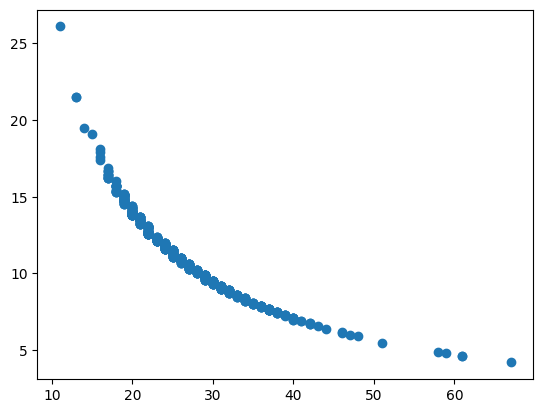

In [22]:
#representamos en un plot la relacion entre las variables comb (L/100 km) y comb (mpg)
plt.scatter(train['Comb (mpg)'],train['Comb (L/100 km)'])

Para pasar de millas por galón a litros por 100 km, vamos a utilizar la siguiente fórmula:
- 1 L/100Km = 282 /mpgImperial

In [23]:
train[['Comb (mpg)','Comb (L/100 km)']].head()

,Comb (mpg),Comb (L/100 km)
0,32,8.7
1,37,7.7
2,24,11.7
3,35,8.1
4,20,13.8


Text(0.5, 1.0, 'Comb (mpg) (redondeado) vs Comb (L/100 km)')

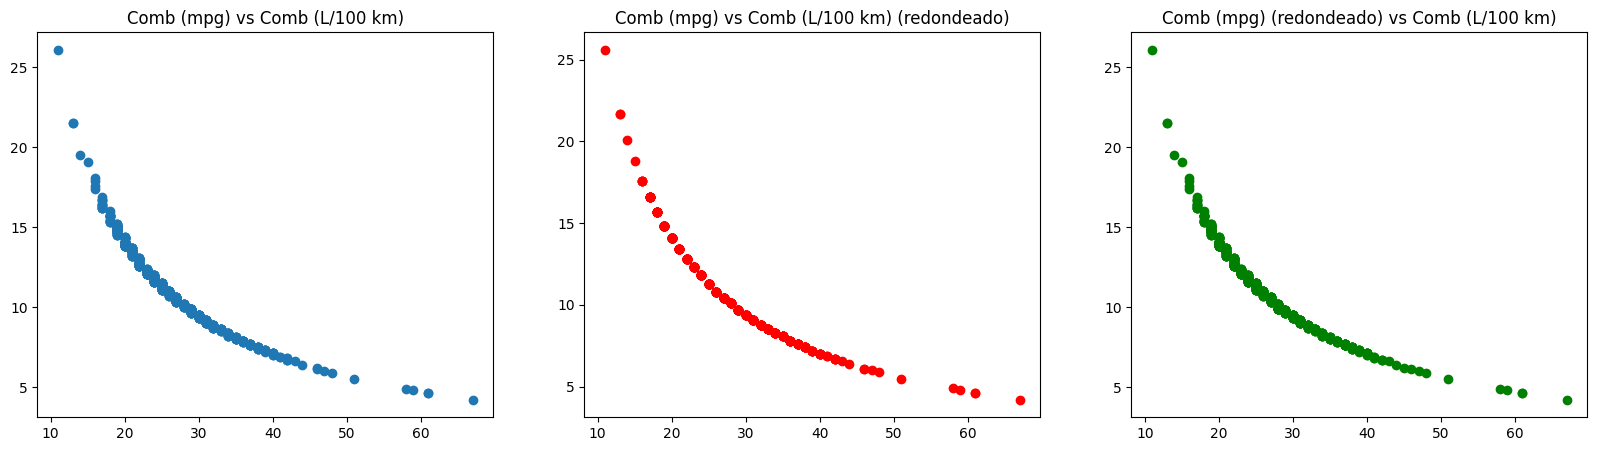

In [24]:
ax,fig = plt.subplots(1,3,figsize=(20,5))

fig[0].scatter(train['Comb (mpg)'],train['Comb (L/100 km)'])
fig[0].set_title('Comb (mpg) vs Comb (L/100 km)')

fig[1].scatter(train['Comb (mpg)'],np.around(282/train['Comb (mpg)'],1),color='red')
fig[1].set_title('Comb (mpg) vs Comb (L/100 km) (redondeado)')

fig[2].scatter(np.around(282/train['Comb (L/100 km)']),train['Comb (L/100 km)'],color='green')
fig[2].set_title('Comb (mpg) (redondeado) vs Comb (L/100 km)')


Text(0.5, 1.0, 'Error redondeo mpg')

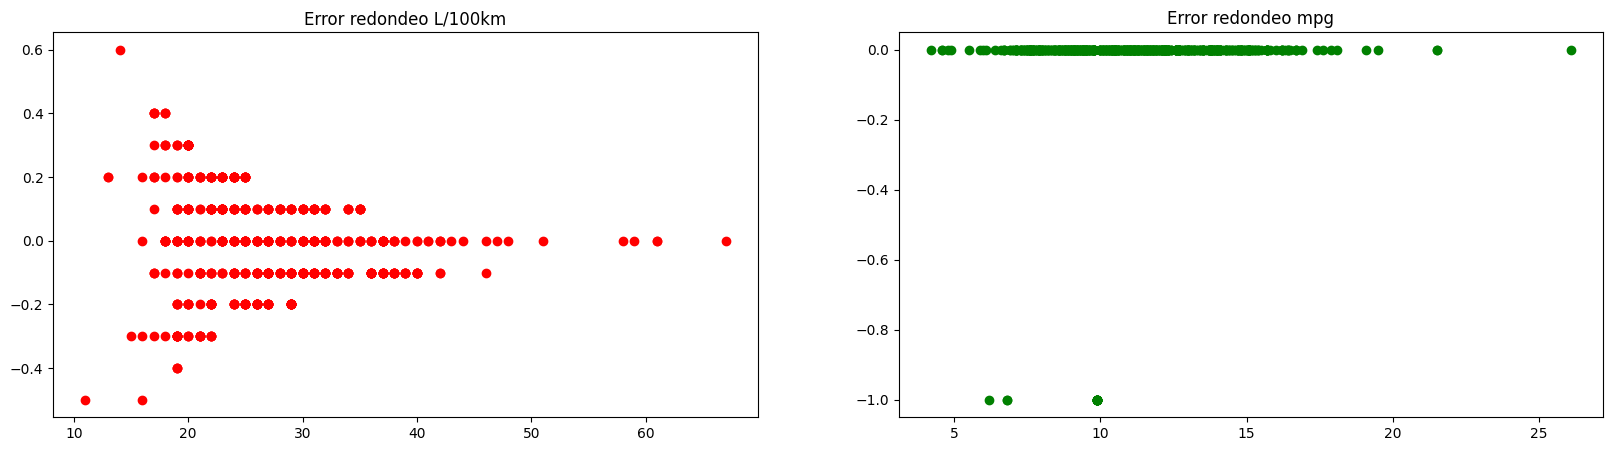

In [25]:

error_redonde_km = np.around(282/train['Comb (mpg)'],1) - train['Comb (L/100 km)']
error_redondeo_mpg = np.around(282/train['Comb (L/100 km)']) - train['Comb (mpg)']

ax, fig = plt.subplots(1,2,figsize=(20,5))


fig[0].scatter(train['Comb (mpg)'],error_redonde_km,color='red')
fig[0].set_title('Error redondeo L/100km')

fig[1].scatter(train['Comb (L/100 km)'],error_redondeo_mpg,color='green')
fig[1].set_title('Error redondeo mpg')


Podemos observar claramente que el atributo Comb (mpg) está calculado a partir de Comb (L/100 km), por lo que podemos eliminarlo. En cuanto a esos outliers de error que son -1, se deben a un error de redondeo en el dataset original

In [26]:
copy = train.copy()
copy['error_redondeo_mpg'] = error_redondeo_mpg

outliers_error = copy[copy['error_redondeo_mpg'] < -0.5]
outliers_error = outliers_error[['Comb (mpg)','Comb (L/100 km)','error_redondeo_mpg']]

In [27]:
outliers_error['calculo_mpg_sin_rendondeo']= 282/outliers_error['Comb (L/100 km)']

In [28]:
outliers_error

,Comb (mpg),Comb (L/100 km),error_redondeo_mpg,calculo_mpg_sin_rendondeo
45,29,9.9,-1.0,28.484848
60,42,6.8,-1.0,41.470588
81,29,9.9,-1.0,28.484848
82,29,9.9,-1.0,28.484848
141,29,9.9,-1.0,28.484848
210,29,9.9,-1.0,28.484848
351,29,9.9,-1.0,28.484848
380,29,9.9,-1.0,28.484848
420,29,9.9,-1.0,28.484848
424,29,9.9,-1.0,28.484848


Text(0.5, 1.0, 'Error redondeo mpg')

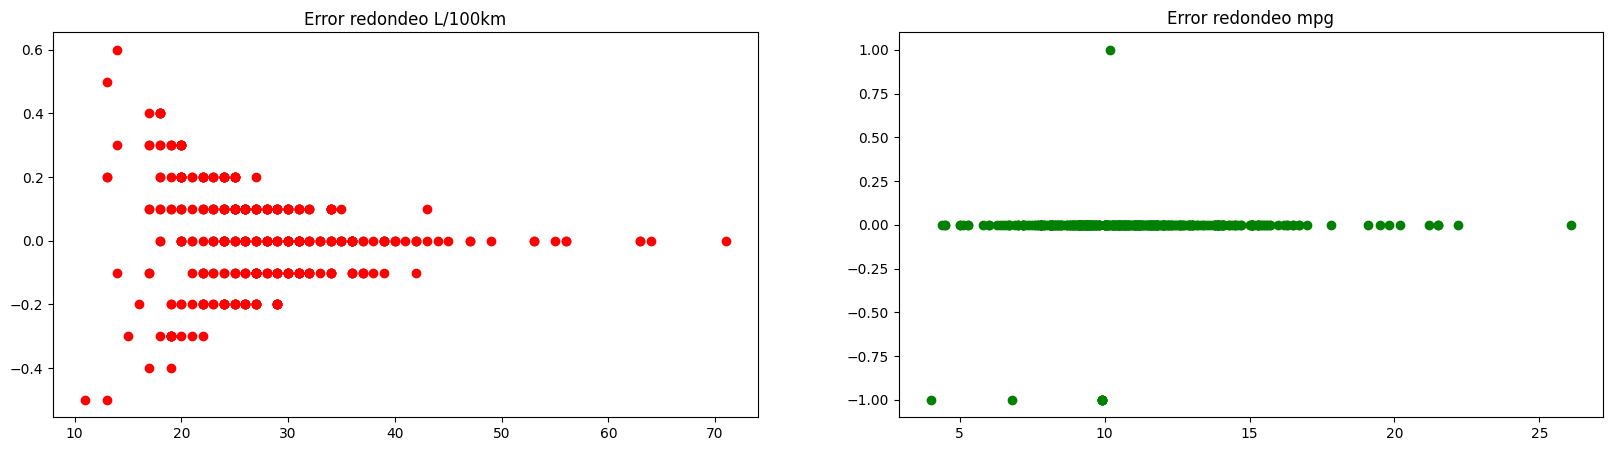

In [29]:

error_redonde_km = np.around(282/test_nolabel['Comb (mpg)'],1) - test_nolabel['Comb (L/100 km)']
error_redondeo_mpg = np.around(282/test_nolabel['Comb (L/100 km)']) - test_nolabel['Comb (mpg)']

ax, fig = plt.subplots(1,2,figsize=(20,5))


fig[0].scatter(test_nolabel['Comb (mpg)'],error_redonde_km,color='red')
fig[0].set_title('Error redondeo L/100km')

fig[1].scatter(test_nolabel['Comb (L/100 km)'],error_redondeo_mpg,color='green')
fig[1].set_title('Error redondeo mpg')

Lo mismo observamos en test pero además se le añaden los errores +1, es decir, ha redondeado hacia abajo el dataset original cuando debería haber redondeado hacia arriba.

In [30]:
copy = test_nolabel.copy()
copy['error_redondeo_mpg'] = error_redondeo_mpg
premisa = (copy['error_redondeo_mpg'] < -0.5) | (copy['error_redondeo_mpg'] > 0.5)
outliers_error = copy[premisa]
outliers_error = outliers_error[['Comb (mpg)','Comb (L/100 km)','error_redondeo_mpg']]
outliers_error['calculo_mpg_sin_rendondeo']= 282/outliers_error['Comb (L/100 km)']
outliers_error

,Comb (mpg),Comb (L/100 km),error_redondeo_mpg,calculo_mpg_sin_rendondeo
3,29,9.9,-1.0,28.484848
15,29,9.9,-1.0,28.484848
31,27,10.2,1.0,27.647059
35,71,4.0,-1.0,70.500000
58,29,9.9,-1.0,28.484848
62,29,9.9,-1.0,28.484848
101,42,6.8,-1.0,41.470588
238,29,9.9,-1.0,28.484848
296,29,9.9,-1.0,28.484848


In [31]:
train = train.drop('Comb (mpg)',axis=1)
test_nolabel = test_nolabel.drop('Comb (mpg)',axis=1)

#### Fuel Consumption City (L/100 km) , Hwy (L/100 km) y Comb (L/100 km)

Ya que uno hace referencia al consumo en ciudad, otro al consumo en carretera y el último al consumo combinado, podemos sacar información de los tres.

In [32]:
train.head()

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog
0,ab44e9bec15,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,202,2
1,45926762371,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,181,4
2,e9be56e153f,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,274,2
3,077092760df,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,189,1
4,c1c2579b795,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,324,1


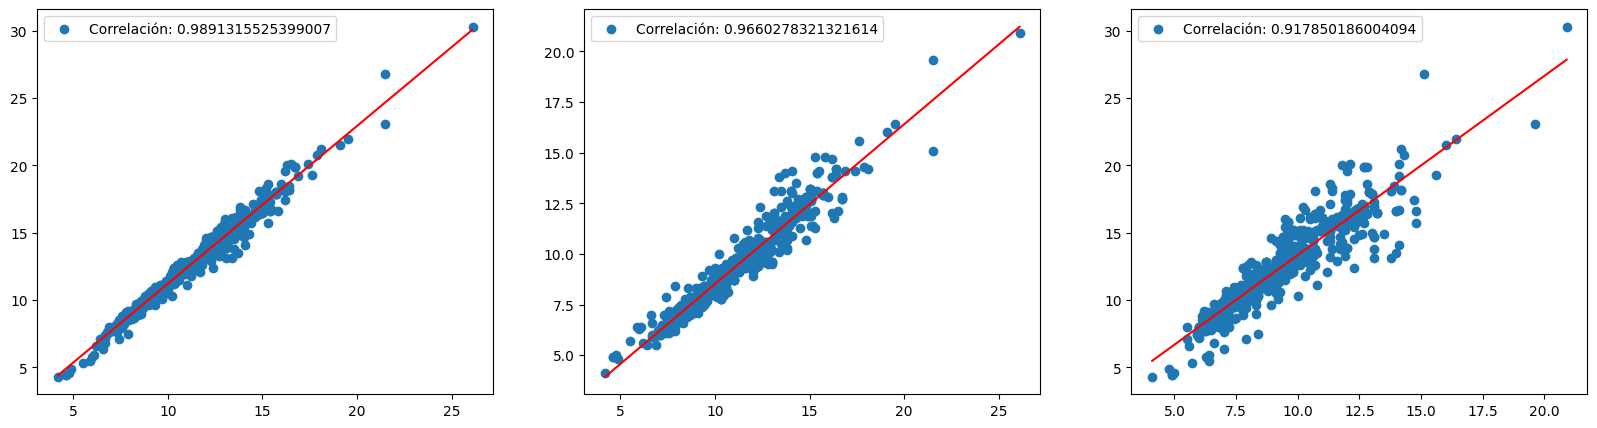

In [33]:
corr_representation(train)


Por las gráficas podemos observar que hay una correlación lineal entres los tres atributos, por lo que podríamos eliminar alguno de ellos. Sin embargo, no lo vamos hacer ya que nos pueden aportar información que nos ayude a predecir mejor.
Aún así dicha correlación la podemos usar para los outliers, es decir, sustituir los valores de los outliers por el calculado a partir de la correlación lineal. 

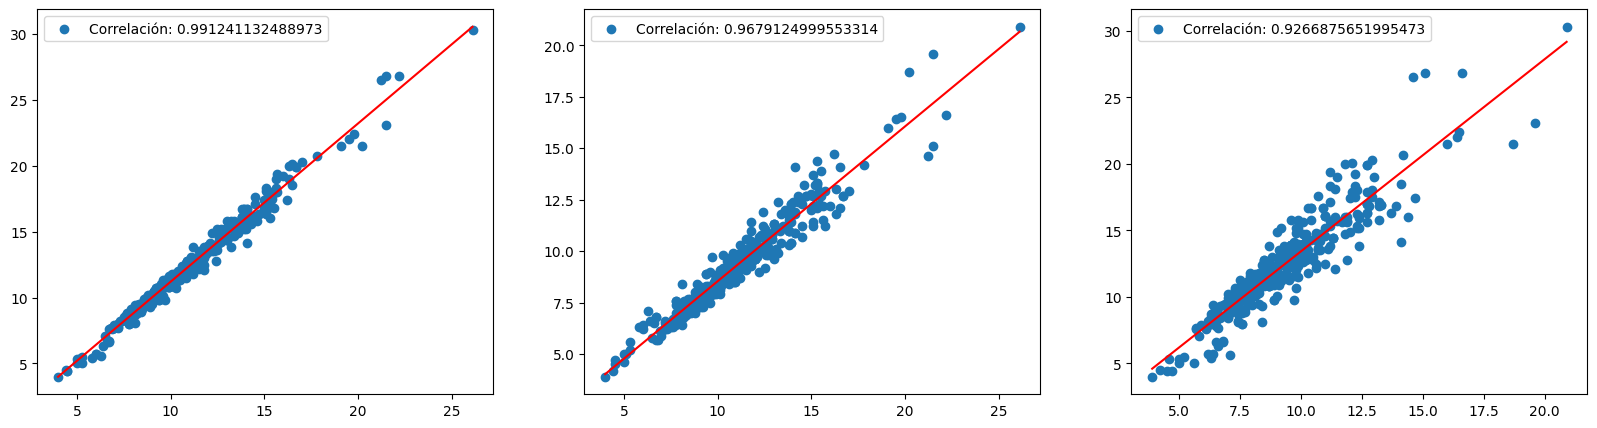

In [34]:
corr_representation(test_nolabel)

En el test encontramos la misma correlación lineal entre los diferentes atributos

Como hemos observado existe una correlación lineal entre los tres atributos. Vamos a estudiar una regresión lineal para ver si podemos predecir el consumo combinado a partir del consumo en ciudad y en carretera.

C:\Users\andre\AppData\Local\Temp\ipykernel_3612\373078864.py:112: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error,ax=fig[1])


r_2: 0.999846023883621
Test de normalidad (kolmogorov-smirnov):
KstestResult(statistic=0.46989132547935175, pvalue=3.4152965448109427e-119, statistic_location=0.07554304429902103, statistic_sign=1)


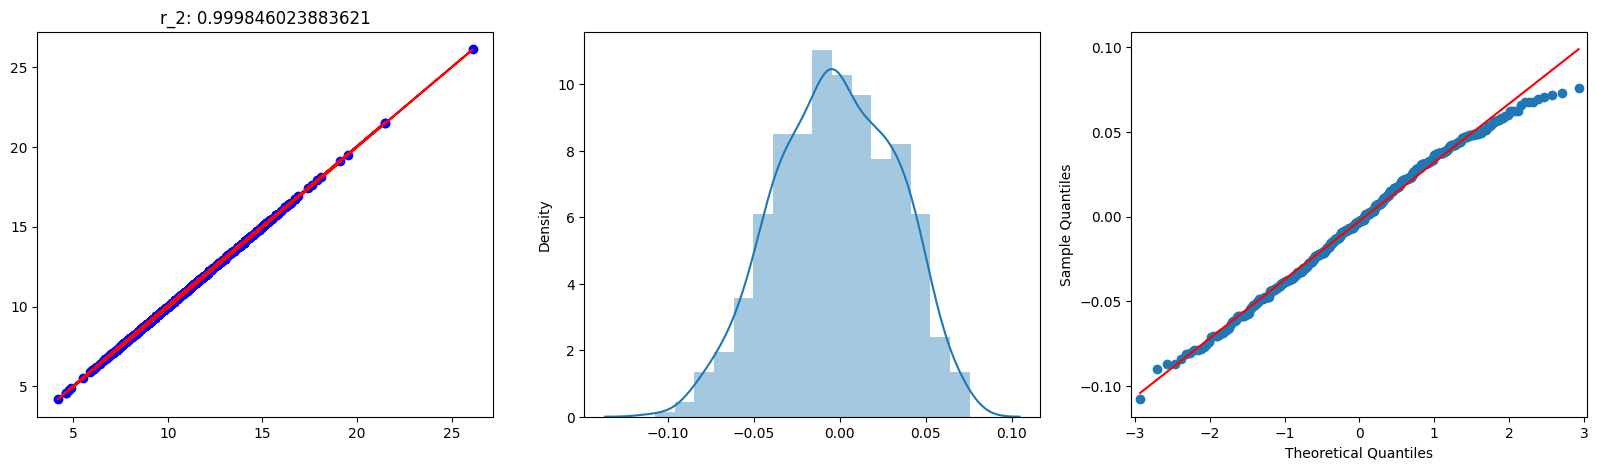

In [35]:
r_2_regresion_lineal(train,['Fuel Consumption City (L/100 km)','Hwy (L/100 km)'],['Comb (L/100 km)'])

C:\Users\andre\AppData\Local\Temp\ipykernel_3612\373078864.py:112: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error,ax=fig[1])


r_2: 0.9997950715122937
Test de normalidad (kolmogorov-smirnov):
KstestResult(statistic=0.46717090607997136, pvalue=1.556743337479084e-78, statistic_location=0.08238343005043447, statistic_sign=1)


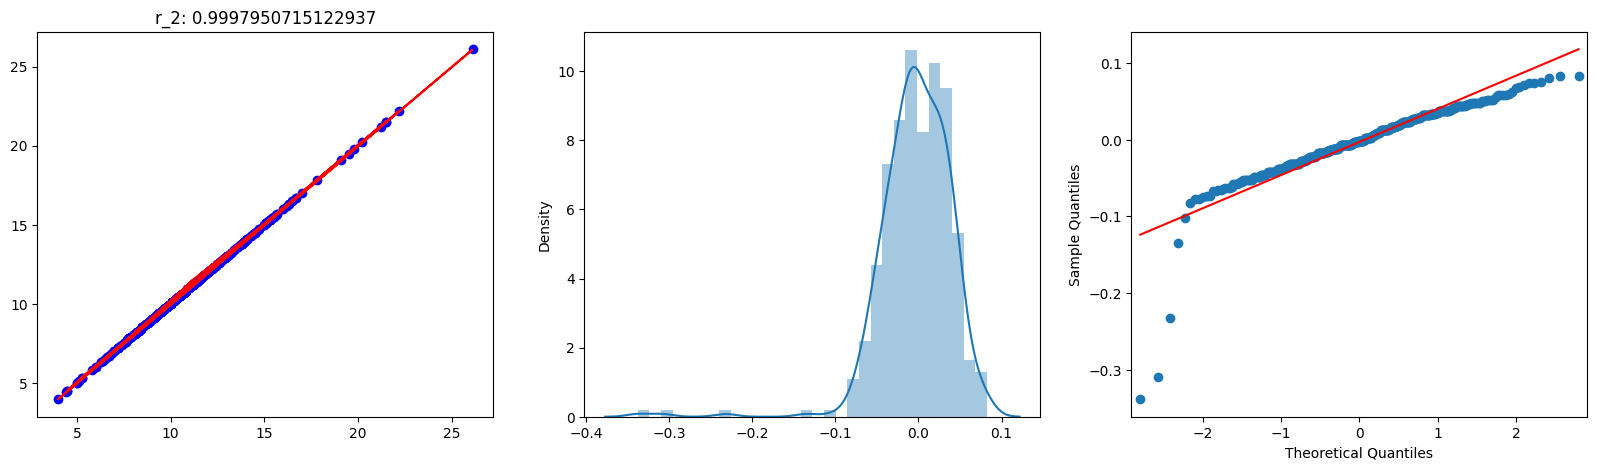

In [36]:
r_2_regresion_lineal(test_nolabel,['Fuel Consumption City (L/100 km)','Hwy (L/100 km)'],['Comb (L/100 km)'])

Podemos observar claramente quq el atributo Comb (L/100 km) está calculado a partir de Fuel Consumption City (L/100 km) y Hwy (L/100 km), por lo que podemos mantener Comb (L/100 km) y eliminar los otros dos. Sin embargo, vamos a mantenerlos todavia para comparar con el atributo CO2 Emissions(g/km).

#### CO2 EMISSIONS 

In [37]:
train.corr()

,Engine Size (L),Cylinders,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog
Engine Size (L),1.000000,0.916857,0.823824,0.722882,0.802054,0.808957,-0.385252
Cylinders,0.916857,1.000000,0.836961,0.716359,0.808126,0.819685,-0.452239
Fuel Consumption City (L/100 km),0.823824,0.836961,1.000000,0.917850,0.989132,0.962071,-0.485874
Hwy (L/100 km),0.722882,0.716359,0.917850,1.000000,0.966028,0.933776,-0.374793
Comb (L/100 km),0.802054,0.808126,0.989132,0.966028,1.000000,0.970278,-0.454922
CO2 Emissions (g/km),0.808957,0.819685,0.962071,0.933776,0.970278,1.000000,-0.481380
Smog,-0.385252,-0.452239,-0.485874,-0.374793,-0.454922,-0.481380,1.000000


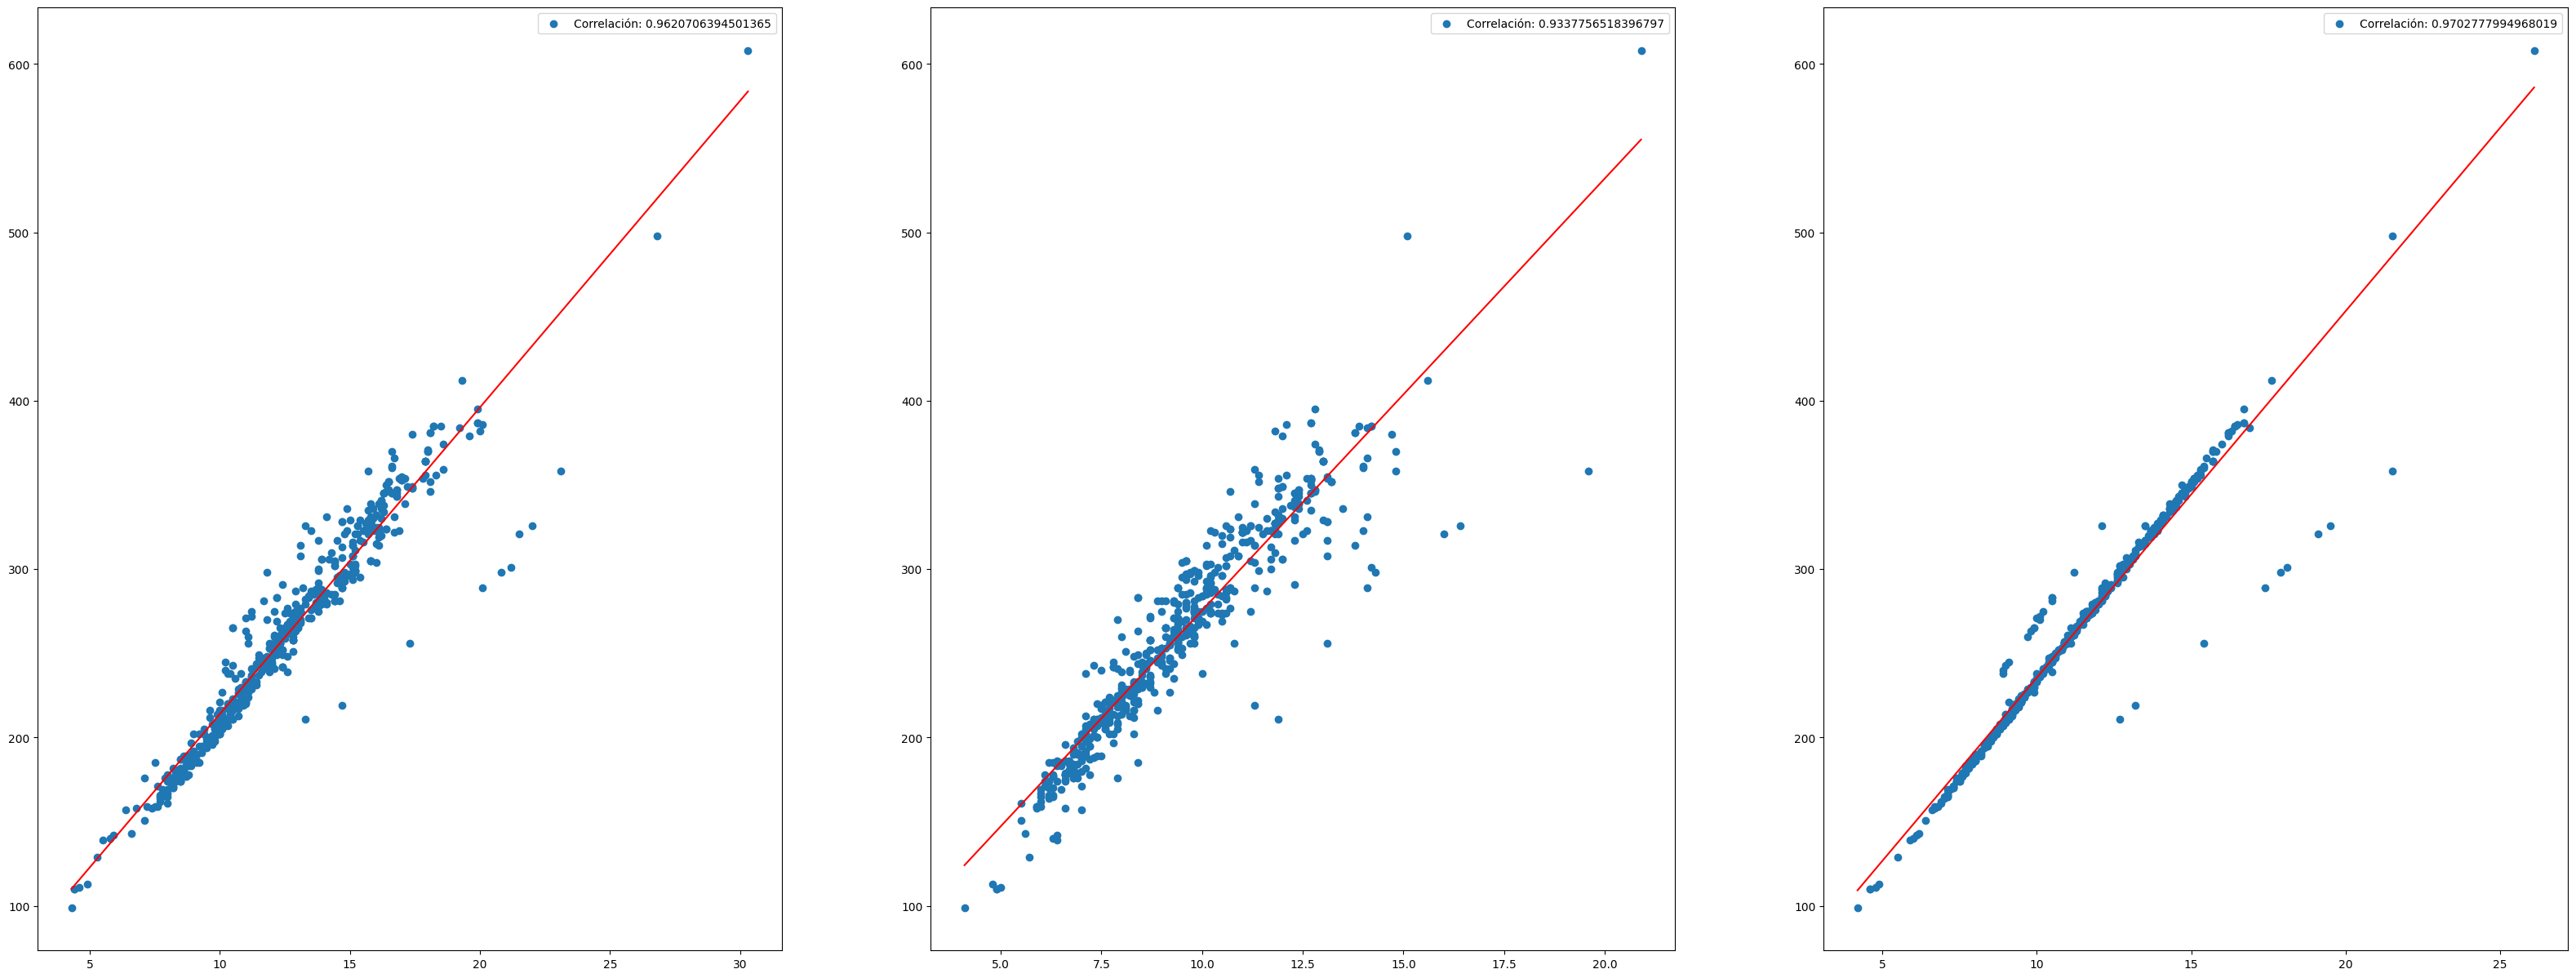

In [38]:
ax, fig = plt.subplots(1,3,figsize=(40,15))

corr_1 = train['Fuel Consumption City (L/100 km)'].corr(train['CO2 Emissions (g/km)'])
corr_2 = train['Hwy (L/100 km)'].corr(train['CO2 Emissions (g/km)'])
corr_3 = train['Comb (L/100 km)'].corr(train['CO2 Emissions (g/km)'])


fig[0].scatter(train['Fuel Consumption City (L/100 km)'],train['CO2 Emissions (g/km)'])
fig[0].plot(np.unique(train['Fuel Consumption City (L/100 km)']), np.poly1d(np.polyfit(train['Fuel Consumption City (L/100 km)'], train['CO2 Emissions (g/km)'], 1))(np.unique(train['Fuel Consumption City (L/100 km)'])),color='red')
fig[0].legend([f'Correlación: {corr_1}'])

fig[1].scatter(train['Hwy (L/100 km)'],train['CO2 Emissions (g/km)'])
fig[1].plot(np.unique(train['Hwy (L/100 km)']), np.poly1d(np.polyfit(train['Hwy (L/100 km)'], train['CO2 Emissions (g/km)'], 1))(np.unique(train['Hwy (L/100 km)'])),color='red')
fig[1].legend([f'Correlación: {corr_2}'])

fig[2].scatter(train['Comb (L/100 km)'],train['CO2 Emissions (g/km)'])
fig[2].plot(np.unique(train['Comb (L/100 km)']), np.poly1d(np.polyfit(train['Comb (L/100 km)'], train['CO2 Emissions (g/km)'], 1))(np.unique(train['Comb (L/100 km)'])),color='red')
fig[2].legend([f'Correlación: {corr_3}'])



Hay existencia de correlación lineal entre CO2 Emissions y los demás atributos, pero no hemos observado una clara combinación lineal entre ellos. Por tanto, vamos a mantener todos los atributos.

In [269]:
#quiero que me haga un boxplot de todas las columnas numericas según las diferentes marcas
columnas_numericas = train.select_dtypes(exclude=['object']).columns
g = sns.PairGrid(train[columnas_numericas], height=4, aspect=0.9)
g.map_upper(sns.regplot,scatter_kws={"color": "red"}, line_kws={"color": "blue"})
g.map_lower(sns.kdeplot, cmap="plasma", shade=True, thresh=0.05)
g.map_diag(plt.hist,color = 'cyan')
plt.tight_layout
plt.show()

Error in callback <function flush_figures at 0x0000024B9699F3A0> (for post_execute):


KeyboardInterrupt: 

Vamos a identificar los outliers del atributo Comb (L/100 km) y vamos a sustituirlos por el valor calculado a partir de la regresión lineal.

In [40]:
index_comb = outliers(pd.DataFrame(train['Comb (L/100 km)'])).index
index_hwy = outliers(pd.DataFrame(train['Hwy (L/100 km)'])).index
index_city = outliers(pd.DataFrame(train['Fuel Consumption City (L/100 km)'])).index
print(index_comb)
print(index_hwy)
print(index_city)

Int64Index([195, 319, 332, 443], dtype='int64')
Int64Index([319, 332, 418, 443], dtype='int64')
Int64Index([195, 332, 443], dtype='int64')


In [41]:
train_drop = train.drop(['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','id','Make','Model','Vehicle Class','Transmission','Fuel Type','Comb (mpg)'],axis=1)

KeyError: "['Comb (mpg)'] not found in axis"

In [ ]:
r2 ,coeficientes = r_2_regresion_lineal(train,['Fuel Consumption City (L/100 km)','Hwy (L/100 km)'],['Comb (L/100 km)'])

Text(0.5, 1.0, 'Coeficiente de determinación: 0.999846023883621')

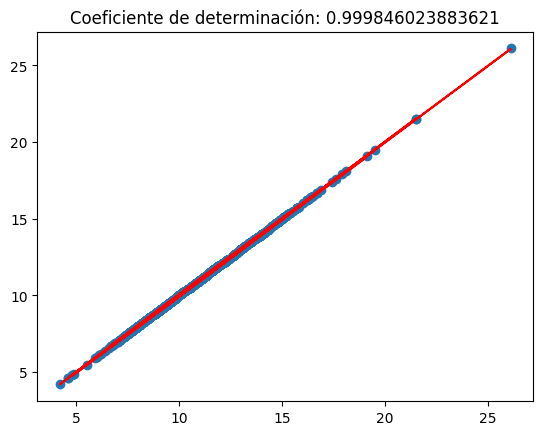

In [ ]:
calculo = coeficientes[0][0]*train['Fuel Consumption City (L/100 km)']+coeficientes[0][1]*train['Hwy (L/100 km)']
plt.plot(train['Comb (L/100 km)'],calculo,color='red')
plt.scatter(train['Comb (L/100 km)'],train['Comb (L/100 km)'])
plt.title(f'Coeficiente de determinación: {r2}')

In [42]:
#quiero observar si el error de la regresion lineal es gaussiano es decir si se distribuye normal
error = train['Comb (L/100 km)'] - calculo



test = stats.kstest(error, 'norm')
test[1]



NameError: name 'calculo' is not defined

In [43]:
train

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog
0,ab44e9bec15,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,202,2
1,45926762371,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,181,4
2,e9be56e153f,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,274,2
3,077092760df,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,189,1
4,c1c2579b795,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,324,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,4a15a420076,BMW,M8 Gran Coupe Competition,Mid-size,4.4,8,AS8,Z,16.1,11.0,13.8,322,1
582,1ff291b6f89,Dodge,Charger (MDS),Full-size,5.7,8,A8,X,14.7,9.4,12.3,289,1
583,ff3fb82f77b,Ram,1500 4X4 EcoDiesel,Pickup truck: Standard,3.0,6,A8,D,11.1,8.0,9.7,260,0
584,cf742d4b653,Honda,Accord Sport/Touring,Full-size,2.0,4,AS10,X,10.4,7.4,9.1,211,4


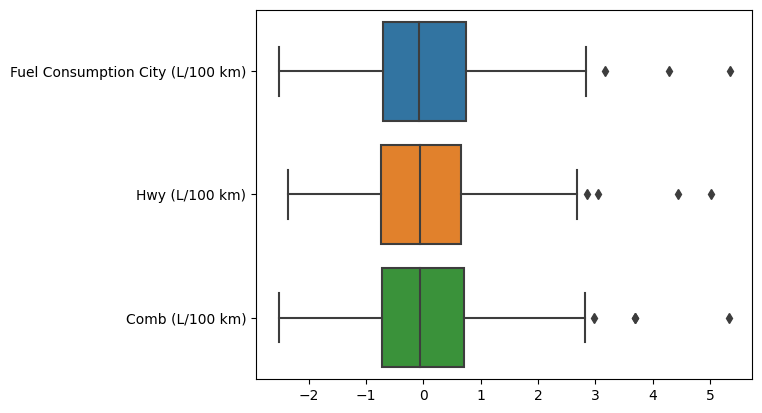

In [44]:
boxplot(train[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','Comb (L/100 km)']])

In [273]:
train

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
0,ab44e9bec15,2022,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,32,202,2
1,45926762371,2022,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,37,181,4
2,e9be56e153f,2022,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,24,274,2
3,077092760df,2022,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,35,189,1
4,c1c2579b795,2022,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,4a15a420076,2022,BMW,M8 Gran Coupe Competition,Mid-size,4.4,8,AS8,Z,16.1,11.0,13.8,20,322,1
582,1ff291b6f89,2022,Dodge,Charger (MDS),Full-size,5.7,8,A8,X,14.7,9.4,12.3,23,289,1
583,ff3fb82f77b,2022,Ram,1500 4X4 EcoDiesel,Pickup truck: Standard,3.0,6,A8,D,11.1,8.0,9.7,29,260,0
584,cf742d4b653,2022,Honda,Accord Sport/Touring,Full-size,2.0,4,AS10,X,10.4,7.4,9.1,31,211,4


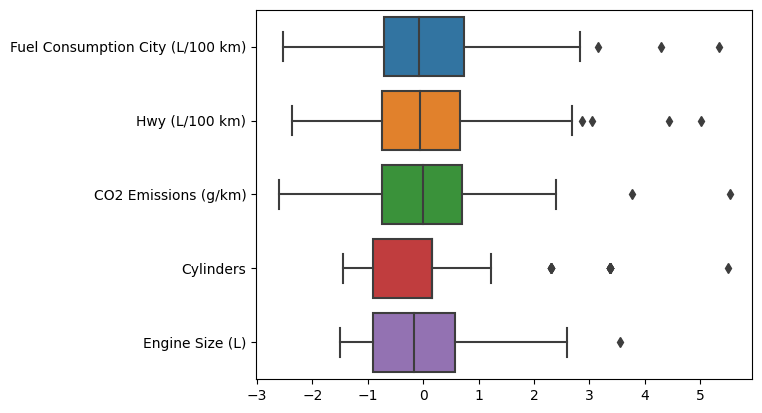

In [287]:
boxplot(train[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','CO2 Emissions (g/km)','Cylinders','Engine Size (L)']])

In [291]:
index = outliers(train[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','CO2 Emissions (g/km)','Cylinders','Engine Size (L)']]).index
outlier = train.loc[index]
outlier['outliers'] = outliers(train[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','CO2 Emissions (g/km)','Cylinders','Engine Size (L)']])['outliers']
outlier

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog,outliers
4,c1c2579b795,2022,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1,[Cylinders]
34,4ee8ba5a71b,2022,Lamborghini,Huracan evo Spyder,Two-seater,5.2,10,AM7,Z,18.0,12.9,15.7,18,371,0,[Cylinders]
68,2900c2e6b2a,2022,Audi,R8 Spyder Performance,Two-seater,5.2,10,AM7,Z,16.7,10.3,13.8,20,322,0,[Cylinders]
69,19419706fbd,2022,Audi,R8 Coupe Performance quattro,Two-seater,5.2,10,AM7,Z,17.9,12.1,15.3,18,356,0,[Cylinders]
76,f60ce250af3,2022,BMW,M760i xDrive Sedan,Full-size,6.6,12,AS8,Z,17.8,11.9,15.1,19,354,1,[Cylinders]
128,990ee624b73,2022,Bentley,Continental GT Speed,Subcompact,6.0,12,AM8,Z,19.6,12.0,16.2,17,379,1,[Cylinders]
195,2fdeb57c0d9,2022,Lamborghini,Aventador Ultimae Roadster,Two-seater,6.5,12,AM7,Z,26.8,15.1,21.5,13,498,0,"[Fuel Consumption City (L/100 km), CO2 Emissio..."
197,e38433dd427,2022,Aston Martin,DB11 V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1,[Cylinders]
218,e84a4cb92ff,2022,Rolls-Royce,Ghost Black Badge,Full-size,6.7,12,AS8,Z,19.9,12.7,16.7,17,387,1,[Cylinders]
285,9ccedbf55c5,2022,Lamborghini,Huracan evo Coupe AWD,Two-seater,5.2,10,AM7,Z,18.0,12.9,15.7,18,370,0,[Cylinders]


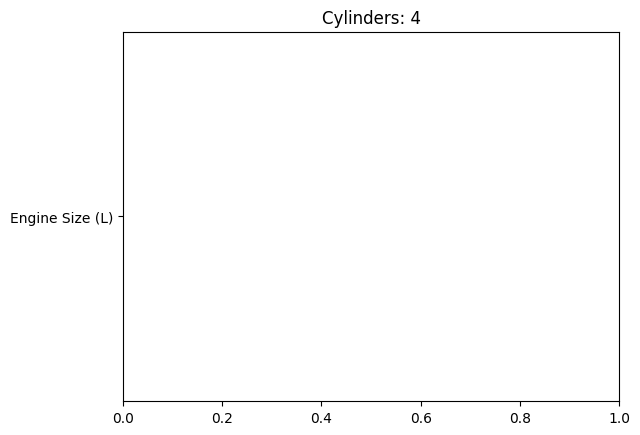

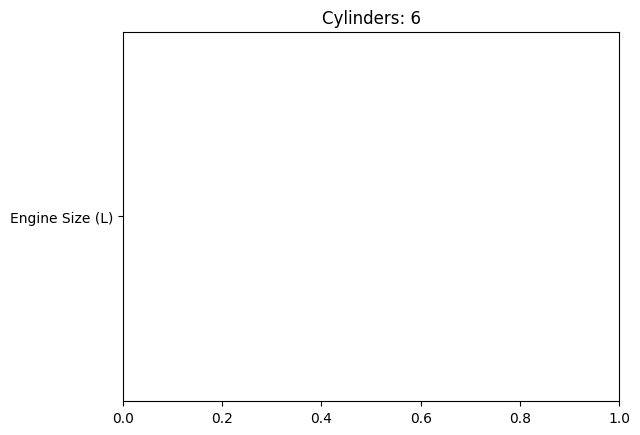

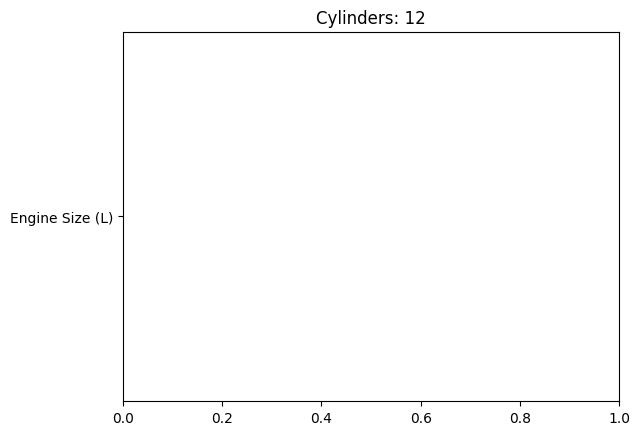

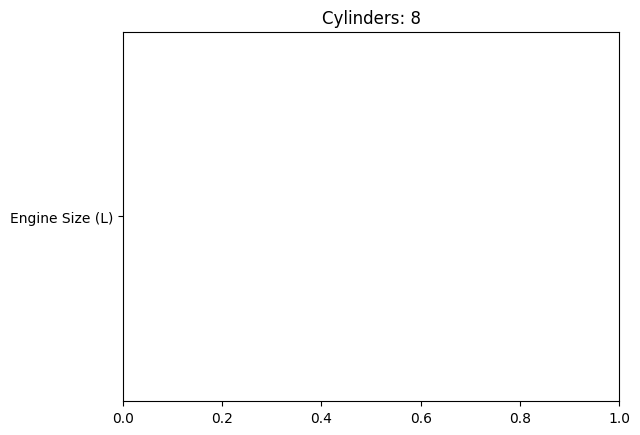

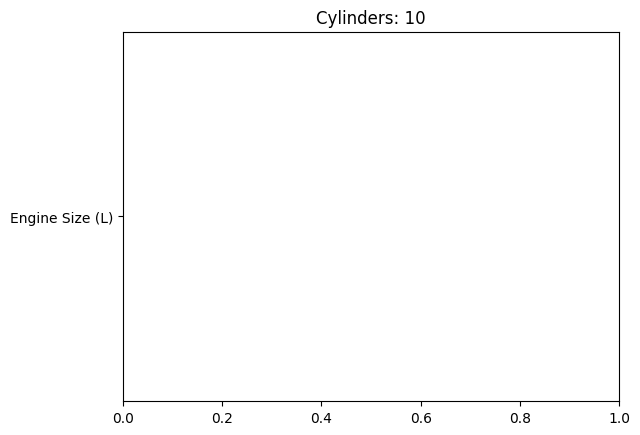

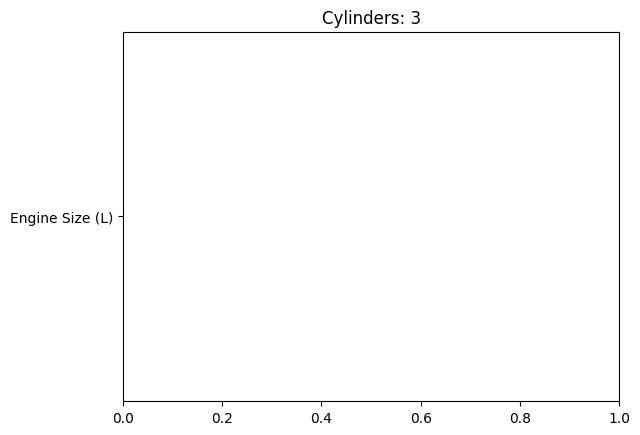

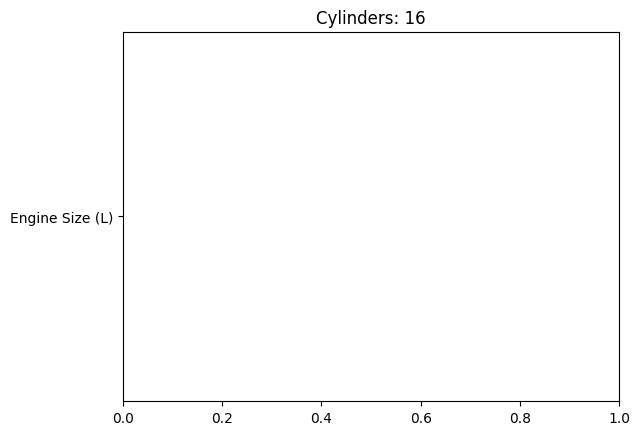

In [295]:
for i in train['Cylinders'].unique():
    boxplot(pd.DataFrame(train[train['Cylinders'] == 3]['Engine Size (L)']))
    plt.title(f'Cylinders: {i}')
    plt.show()

Gracias al boxplot encontramos los outliers de los tres atributos

In [46]:
outlier_consumo_train = outliers(train[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','Comb (L/100 km)']])
out = outlier_consumo_train['outliers']
outlier_consumo_train = train.loc[outlier_consumo_train.index]
outlier_consumo_train['outliers'] = out

outlier_consumo_test = outliers(test_nolabel[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','Comb (L/100 km)']])
out = outlier_consumo_test['outliers']
outlier_consumo_test = test_nolabel.loc[outlier_consumo_test.index]
outlier_consumo_test['outliers'] = out

In [47]:
outlier_consumo_train

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog,outliers
195,2fdeb57c0d9,Lamborghini,Aventador Ultimae Roadster,Two-seater,6.5,12,AM7,Z,26.8,15.1,21.5,498,0,"[Fuel Consumption City (L/100 km), Comb (L/100..."
319,a98965d6869,GMC,Sierra 4WD FFV,Pickup truck: Standard,5.3,8,A6,E,22.0,16.4,19.5,326,1,"[Hwy (L/100 km), Comb (L/100 km)]"
332,55f27a7ed4a,GMC,Sierra 4WD Mud Terrain Tire FFV,Pickup truck: Standard,5.3,8,A6,E,23.1,19.6,21.5,358,1,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."
418,ffc797bb6e6,GMC,Sierra FFV,Pickup truck: Standard,5.3,8,A6,E,21.5,16.0,19.1,321,1,[Hwy (L/100 km)]
443,5ba1e8ce15f,Bugatti,Chiron Pur Sport,Two-seater,8.0,16,AM7,Z,30.3,20.9,26.1,608,0,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."


In [48]:
outlier_consumo_test

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),outliers
35,11f073fbf9c,Hyundai,IONIQ Blue,Full-size,1.6,4,AM6,X,4.0,3.9,4.0,94,[Fuel Consumption City (L/100 km)]
63,eb98a3e05d1,Bugatti,Chiron,Two-seater,8.0,16,AM7,Z,26.8,16.6,22.2,522,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."
111,f231e384fcb,Bugatti,Chiron Super Sport,Two-seater,8.0,16,AM7,Z,30.3,20.9,26.1,608,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."
133,72eab9a6fd9,Ram,1500 4X4 TRX,Pickup truck: Standard,6.2,8,A8,Z,22.4,16.5,19.8,465,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."
215,44deb19dfc9,Chevrolet,Silverado FFV,Pickup truck: Standard,5.3,8,A6,E,21.5,16.0,19.1,321,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."
263,a4b1bbfe887,Chevrolet,Silverado 4WD Mud Terrain Tire FFV,Pickup truck: Standard,5.3,8,A6,E,23.1,19.6,21.5,358,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."
279,93289ba1d46,Chevrolet,Silverado 4WD FFV,Pickup truck: Standard,5.3,8,A6,E,22.0,16.4,19.5,326,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."
298,eb474ad448f,Lamborghini,Aventador Countach,Two-seater,6.5,12,AM7,Z,26.5,14.6,21.2,489,"[Fuel Consumption City (L/100 km), Comb (L/100..."
302,008baf297b8,Mercedes-Benz,AMG G 63 4x4 Squared,SUV: Standard,4.0,8,A9,Z,21.5,18.7,20.2,470,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."
331,cc52460cd6c,Ford,F-150 4X4 FFV (Without Stop-Start),Pickup truck: Standard,5.0,8,AS10,E,20.7,14.2,17.8,295,[Fuel Consumption City (L/100 km)]


<Axes: xlabel='Make', ylabel='Smog'>

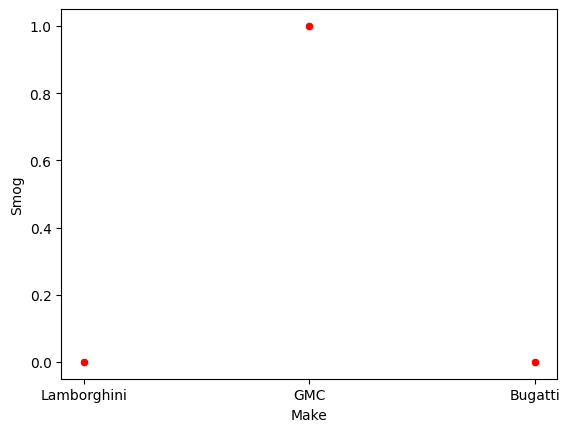

In [49]:
sns.scatterplot(x='Make',y='Smog',data=outlier_consumo_train,color='red')



In [51]:
#comprueba si hay filas en train q se repiten en test

train['id'].isin(test_nolabel['id']).any()

False

In [52]:
train.corr()

,Engine Size (L),Cylinders,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog
Engine Size (L),1.000000,0.916857,0.823824,0.722882,0.802054,0.808957,-0.385252
Cylinders,0.916857,1.000000,0.836961,0.716359,0.808126,0.819685,-0.452239
Fuel Consumption City (L/100 km),0.823824,0.836961,1.000000,0.917850,0.989132,0.962071,-0.485874
Hwy (L/100 km),0.722882,0.716359,0.917850,1.000000,0.966028,0.933776,-0.374793
Comb (L/100 km),0.802054,0.808126,0.989132,0.966028,1.000000,0.970278,-0.454922
CO2 Emissions (g/km),0.808957,0.819685,0.962071,0.933776,0.970278,1.000000,-0.481380
Smog,-0.385252,-0.452239,-0.485874,-0.374793,-0.454922,-0.481380,1.000000


In [58]:
train = train.drop('Comb (L/100 km)',axis=1)
test_nolabel = test_nolabel.drop('Comb (L/100 km)',axis=1)

### Variables categóricas

- Make: marca del coche
- Model: modelo del coche
- Vehicle Class: clase del vehículo
- Transmission: tipo de transmisión, que puede ser automática o manual
- Fuel Type: tipo de combustible

Hay demasiados valores diferentes para Model en relación al número de instancias. Por tanto, es difícil para los modelos extraer información particular asociada a cada modelo en particular.

In [215]:
train = train.drop('Model',axis=1)
test_nolabel = test_nolabel.drop('Model',axis=1)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

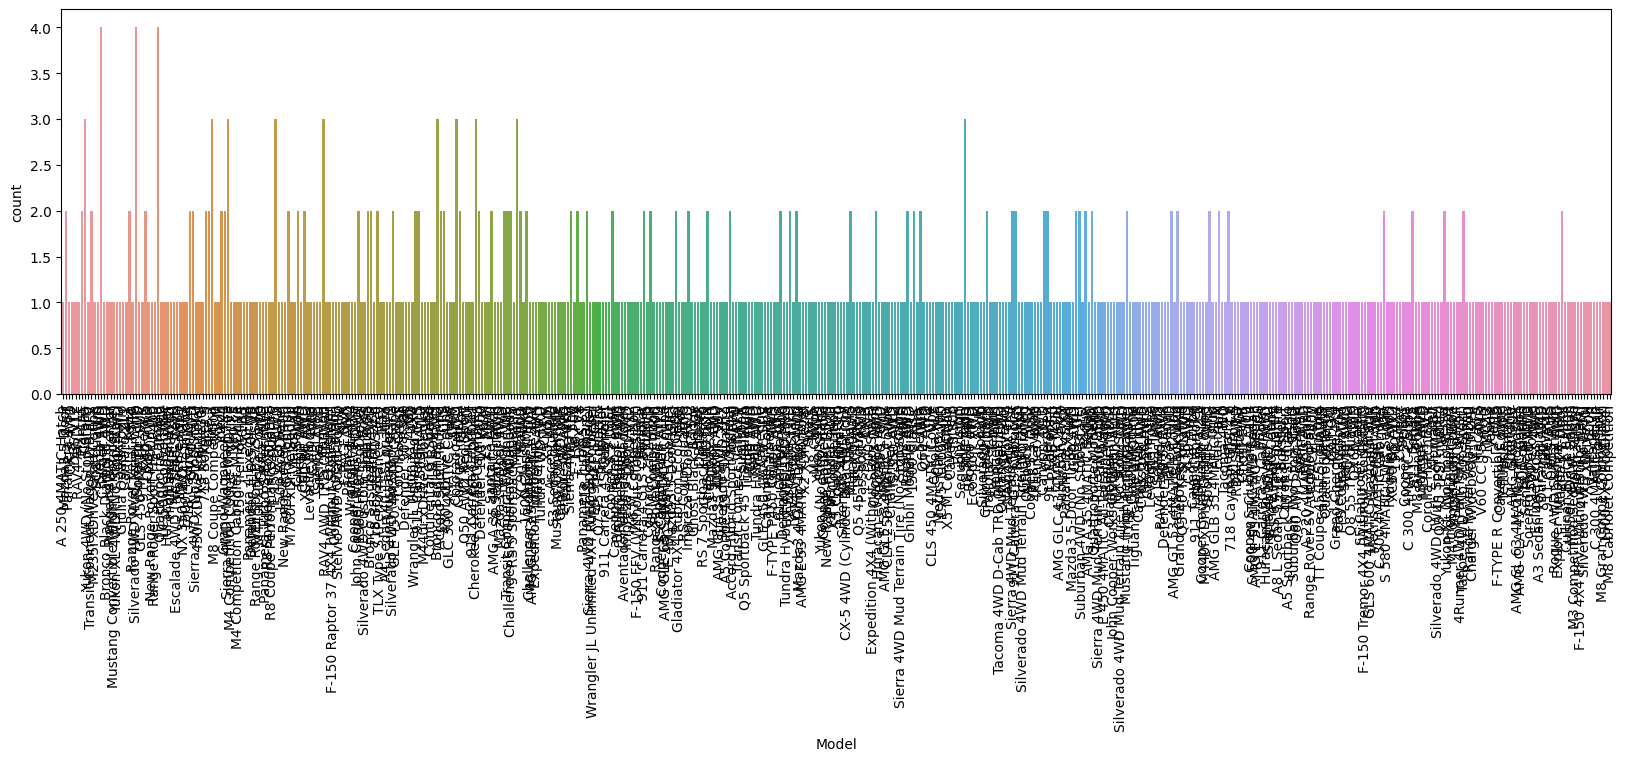

In [314]:
#historgrama de modelos
plt.figure(figsize=(20,5))
sns.countplot(x='Model',data=train)
plt.xticks(rotation=90)


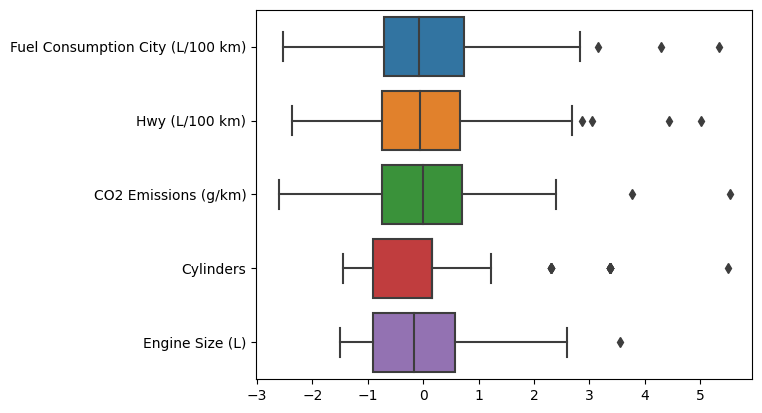

In [307]:
boxplot(train[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','CO2 Emissions (g/km)','Cylinders','Engine Size (L)']])  

In [309]:
outliers(train)

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog,outliers
4,c1c2579b795,2022,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1,[Cylinders]
34,4ee8ba5a71b,2022,Lamborghini,Huracan evo Spyder,Two-seater,5.2,10,AM7,Z,18.0,12.9,15.7,18,371,0,[Cylinders]
55,fbbcebc9b93,2022,Kia,Niro FE,Station wagon: Small,1.6,4,AM6,X,4.4,4.9,4.6,61,110,4,[Comb (mpg)]
68,2900c2e6b2a,2022,Audi,R8 Spyder Performance,Two-seater,5.2,10,AM7,Z,16.7,10.3,13.8,20,322,0,[Cylinders]
69,19419706fbd,2022,Audi,R8 Coupe Performance quattro,Two-seater,5.2,10,AM7,Z,17.9,12.1,15.3,18,356,0,[Cylinders]
76,f60ce250af3,2022,BMW,M760i xDrive Sedan,Full-size,6.6,12,AS8,Z,17.8,11.9,15.1,19,354,1,[Cylinders]
128,990ee624b73,2022,Bentley,Continental GT Speed,Subcompact,6.0,12,AM8,Z,19.6,12.0,16.2,17,379,1,[Cylinders]
195,2fdeb57c0d9,2022,Lamborghini,Aventador Ultimae Roadster,Two-seater,6.5,12,AM7,Z,26.8,15.1,21.5,13,498,0,"[Cylinders, Fuel Consumption City (L/100 km), ..."
197,e38433dd427,2022,Aston Martin,DB11 V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1,[Cylinders]
207,1318a48abac,2022,Ford,Escape Hybrid AWD,SUV: Small,2.5,4,AV,X,5.5,6.4,5.9,48,139,4,[Comb (mpg)]


In [306]:
#vamos a estudiar a traves de estaditicos la relación entre las variables categoricas

#nominal
'''
Coeficinte de contingencia
Phil y V Cramer
Coeficiente de incertidumbre
'''

#Phil y V Cramer
#Para usar este coeficiente las variables tienen que ser nominales y debemos implementar un test de chi cuadrado
#para ver si son dependientes o independientes, para ello usamos la funcion chi2_contingency de scipy.stats
#si el p-valor es menor que 0.05 las variables son dependientes y si es mayor son independientes
from scipy.stats import chi2_contingency

def chi2(df,column1,column2):
    '''Devuelve el test de chi2 y el p-valor'''
    contingency_table = pd.crosstab(df[column1],df[column2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2,p

chi2(train,'Vehicle Class','Fuel Type')

(283.8119930187612, 6.314055800778087e-39)

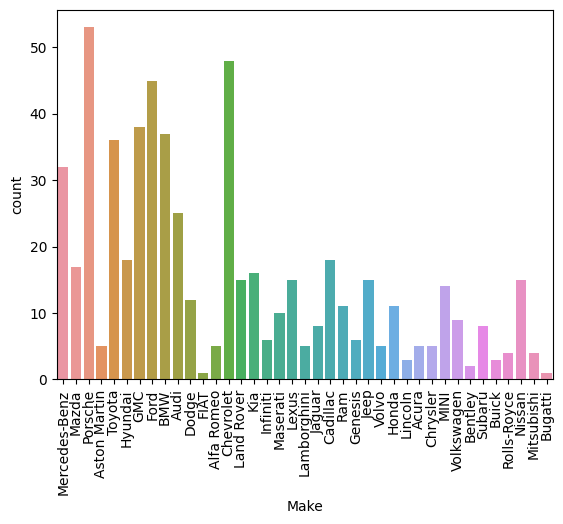

In [232]:
sns.countplot(x='Make',data=train)
plt.xticks(rotation=90)
plt.show()

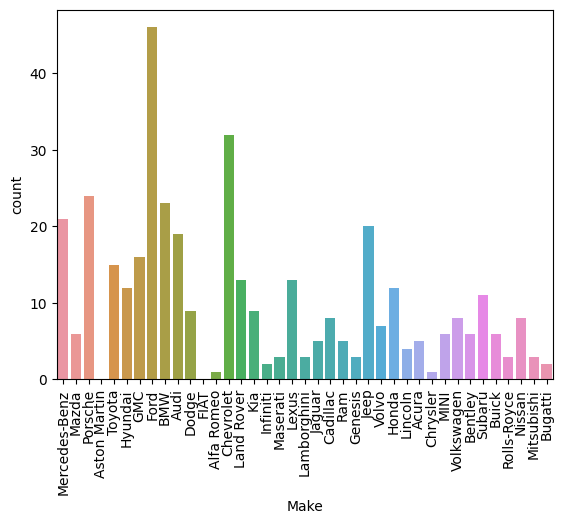

In [234]:
#lo mismo pero con test y que mantenga el orden de train
sns.countplot(x='Make',data=test_nolabel,order=train['Make'].unique())
plt.xticks(rotation=90)
plt.show()

In [236]:
#quiero un nuevo dataset a partir de train que tenga una distribución de 'make' similar a la de test
#primero voy a ver la distribución de 'make' en train
train['Make'].value_counts()

#ahora voy a ver la distribución de 'make' en test
test_nolabel['Make'].value_counts()

#voy a crear un nuevo dataset a partir de train que tenga una distribución de 'make' similar a la de test
#primero voy a crear un diccionario con la distribución de 'make' en test
dict = {}
for i in test_nolabel['Make'].unique():
    dict[i] = test_nolabel['Make'].value_counts()[i]

#ahora voy a crear un nuevo dataset a partir de train que tenga una distribución de 'make' similar a la de test
train_new = pd.DataFrame()
for i in dict.keys():
    train_new = train_new.append(train[train['Make'] == i].sample(dict[i],random_state=42,replace=True))



C:\Users\andre\AppData\Local\Temp\ipykernel_3612\862783699.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_new = train_new.append(train[train['Make'] == i].sample(dict[i],random_state=42,replace=True))
C:\Users\andre\AppData\Local\Temp\ipykernel_3612\862783699.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_new = train_new.append(train[train['Make'] == i].sample(dict[i],random_state=42,replace=True))
C:\Users\andre\AppData\Local\Temp\ipykernel_3612\862783699.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_new = train_new.append(train[train['Make'] == i].sample(dict[i],random_state=42,replace=True))
C:\Users\andre\AppData\Local\Temp\ipykernel_3612\862783699.py:17: FutureWarning: The frame.app

In [245]:
train_new = train_new.drop(['id','Model Year','Comb (L/100 km)','Comb (mpg)'],axis=1)


KeyError: "['id', 'Model Year', 'Comb (L/100 km)', 'Comb (mpg)'] not found in axis"

In [247]:
test_1 = test_nolabel.drop(['id','Model Year','Comb (L/100 km)','Comb (mpg)'],axis=1)

In [243]:
#one hot encoding para las columnas que son string
train_new = pd.get_dummies(train_new,columns=['Make','Vehicle Class','Transmission','Fuel Type'])


In [248]:
test_1 = pd.get_dummies(test_1,columns=['Make','Vehicle Class','Transmission','Fuel Type'])

In [249]:
#añadri las columnas que tiene train_new y no tiene test_1

for i in train_new.columns:
    if i not in test_1.columns:
        test_1[i] = 0
        

In [260]:
#añadri las columnas que tiene test_1 y no tiene train_new

for i in test_1.columns:
    if i not in train_new.columns:
        train_new[i] = 0

In [261]:
#bagging
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier

model = BaggingRegressor(base_estimator=RandomForestClassifier(),n_estimators=100,random_state=42)
model.fit(train_new.drop('Smog',axis=1),train_new['Smog'])


c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingRegressor(base_estimator=RandomForestClassifier(), n_estimators=100,
                 random_state=42)

In [251]:
predicciones = model.predict(train_new.drop('Smog',axis=1))

In [254]:
predicciones = np.around(predicciones)
from sklearn.metrics import f1_score
f1_score(train_new['Smog'],predicciones,average='macro')

0.9514214180241007

In [258]:
train_new
test_1.drop(['Smog','Model'],axis=1,inplace=True)

In [266]:
#ordenar las columnas de test_1 para que coincidan con las de train_new
train_new1 = train_new.drop('Smog',axis=1)
test_1 = test_1[train_new1.columns]

In [267]:
predicciones = model.predict(test_1)

In [268]:
csv(predicciones,'predicciones_validacion.csv',test_nolabel)

In [211]:
train_1 = train.copy()
train_1['Suma'] = train_1['Engine Size (L)']+train_1['Cylinders']
train_1['mul'] = -train_1['Fuel Consumption City (L/100 km)'] - train_1['Hwy (L/100 km)']-train_1['Comb (L/100 km)']-train_1['CO2 Emissions (g/km)']-train_1['Engine Size (L)']-train_1['Cylinders']

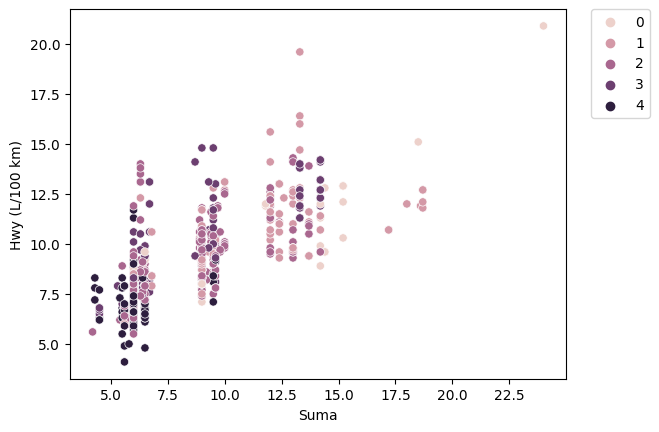

In [212]:
sns.scatterplot(data=train_1, x="Suma", y="Hwy (L/100 km)", hue="Smog")
#quiero el leng mas pequeño y esquina supeiror izquierda
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Codificación de variables categóricas

In [160]:
#Codificación target encoding
train_target = train.copy()
test_target = test_nolabel.copy()
encoder = TargetEncoder(cols=['Make','Vehicle Class','Transmission','Fuel Type'], smoothing=0.1)
encoder.fit(train_target,train_target['CO2 Emissions (g/km)'])
encoder_1 = TargetEncoder(cols=['Make','Vehicle Class','Transmission','Fuel Type'], smoothing=0.1)
encoder_1.fit(test_target,test_target['CO2 Emissions (g/km)'])  


TargetEncoder(cols=['Make', 'Vehicle Class', 'Transmission', 'Fuel Type'],
              smoothing=0.1)

In [161]:
train_target = encoder.transform(train_target)
test_target = encoder_1.transform(test_target)

In [162]:
#codificación one-hot
train_one_hot = train.copy()
test_one_hot = test_nolabel.copy()

train_one_hot = pd.get_dummies(train_one_hot,columns=['Make','Vehicle Class','Transmission','Fuel Type'])
test_one_hot = pd.get_dummies(test_one_hot,columns=['Make','Vehicle Class','Transmission','Fuel Type'])


In [171]:
#codificaión binaria
train_binary = train.copy()
test_binary = test_nolabel.copy()
lista = ['Make','Vehicle Class','Transmission','Fuel Type']
encoder = BinaryEncoder(cols=lista)
encoder.fit(train_binary,train_binary['Smog'])
train_binary = encoder.transform(train_binary)

#el encoder lo he ajustado con Smg, pero en test no hay Smog, com

In [164]:
#codificacion hashing
from category_encoders import HashingEncoder
train_hashing = train.copy()
test_hashing = test_nolabel.copy()
lista = ['Make','Vehicle Class','Transmission','Fuel Type']
encoder = HashingEncoder(cols=lista)
encoder.fit(train_hashing,train_hashing['Smog'])
train_hashing = encoder.transform(train_hashing)

In [89]:
train_binary

,id,Make_0,Make_1,Make_2,Make_3,Make_4,Make_5,Vehicle Class_0,Vehicle Class_1,Vehicle Class_2,...,Transmission_2,Transmission_3,Transmission_4,Fuel Type_0,Fuel Type_1,Fuel Type_2,Fuel Consumption City (L/100 km),Hwy (L/100 km),CO2 Emissions (g/km),Smog
0,ab44e9bec15,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,10.0,7.0,202,2
1,45926762371,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,8.6,6.7,181,4
2,e9be56e153f,0,0,0,0,1,1,0,0,1,...,0,1,1,0,0,1,12.8,10.2,274,2
3,077092760df,0,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0,8.6,7.4,189,1
4,c1c2579b795,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,1,16.4,10.7,324,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,4a15a420076,0,0,1,0,0,1,0,0,1,...,1,0,1,0,0,1,16.1,11.0,322,1
582,1ff291b6f89,0,0,1,0,1,1,0,0,1,...,1,0,0,0,1,0,14.7,9.4,289,1
583,ff3fb82f77b,0,1,0,1,1,1,1,0,0,...,1,0,0,1,0,0,11.1,8.0,260,0
584,cf742d4b653,0,1,1,0,1,1,0,0,1,...,0,0,0,0,1,0,10.4,7.4,211,4


In [165]:
train_binary = train_binary.drop('id',axis=1)
train_one_hot = train_one_hot.drop('id',axis=1)
train_target = train_target.drop('id',axis=1)
train_hashing = train_hashing.drop('id',axis=1)

In [93]:
#trainsplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_binary.drop('Smog',axis=1),train_binary['Smog'], test_size=0.2, random_state=42)

In [119]:
from sklearn.ensemble import RandomForestClassifier
#cross validation
from sklearn.model_selection import cross_val_predict
#svm
from sklearn.svm import SVC
model = SVC()

predictions = cross_val_predict(model, train_binary.drop('Smog',axis=1), train_binary['Smog'], cv=3)

In [122]:
#f1 score
from sklearn.metrics import f1_score
f1_score(train_binary['Smog'],predictions,average='macro')

0.3165852675275659

In [316]:
#####0,85

from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

lista =[train_hashing,train_target,train_one_hot,train_binary]
x=lista[2]

model = BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10,random_state=0)
predictions = cross_val_predict(model, x.drop('Smog',axis=1), x['Smog'], cv=3)
f1_score(x['Smog'],predictions,average='macro')

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7823983819528859

In [318]:
x

,Engine Size (L),Cylinders,Fuel Consumption City (L/100 km),Hwy (L/100 km),CO2 Emissions (g/km),Smog,Make_Acura,Make_Alfa Romeo,Make_Aston Martin,Make_Audi,...,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Fuel Type_D,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,2.0,4,10.0,7.0,202,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.0,4,8.6,6.7,181,4,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.9,6,12.8,10.2,274,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.0,4,8.6,7.4,189,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5.2,12,16.4,10.7,324,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,4.4,8,16.1,11.0,322,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
582,5.7,8,14.7,9.4,289,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
583,3.0,6,11.1,8.0,260,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
584,2.0,4,10.4,7.4,211,4,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [317]:
#con este modelo quiero predecir test_one_hot
#0,85
model.fit(x.drop('Smog',axis=1),x['Smog'])
predictions = model.predict(x.drop('Smog',axis=1))
f1_score(train_one_hot['Smog'],predictions,average='macro')

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9882787251450565

In [181]:
#matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(train_binary['Smog'],predictions)

array([[ 32,   1,   0,   0,   0],
       [  0, 124,   1,   0,   0],
       [  0,   1, 196,   0,   0],
       [  0,   1,   1, 110,   0],
       [  0,   1,   1,   0, 117]], dtype=int64)

In [182]:
#añadir columnas a test_one_hot que estan en train_one_hot pero no en test_one_hot y poner 0
train_one_hot.columns.difference(test_one_hot.columns)

for i in train_one_hot.columns.difference(test_one_hot.columns):
    test_one_hot[i] = 0

In [183]:
test_one_hot = test_one_hot[train_one_hot.columns]

In [185]:
predictions = model.predict(test_one_hot.drop('Smog',axis=1))

In [186]:
csv(predictions,'one_hot_decision_tree.csv',test_nolabel)

In [144]:
model = BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10,random_state=0)
#grid search
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [10, 100, 1000], 'max_features': [2]}
grid = GridSearchCV(model, param_grid, cv=3)
grid.fit(x.drop('Smog',axis=1),x['Smog'])
grid.best_params_

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWar

KeyboardInterrupt: 

In [140]:
csv(predictions,'prueba_one_hot.csv',test_nolabel)

<Axes: xlabel='Smog', ylabel='count'>

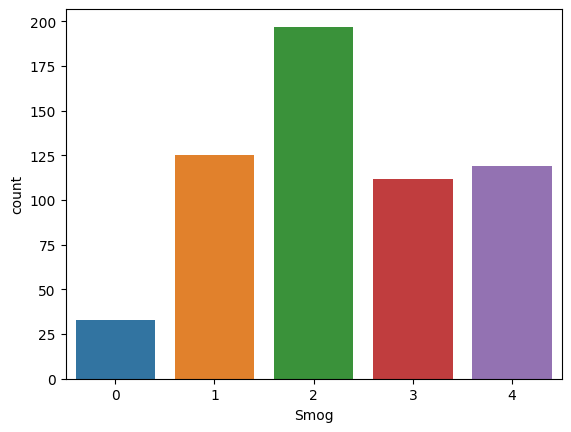

In [319]:
#historgram de smog
sns.countplot(x='Smog',data=train_binary)